# **Tensor Network: Quantum-Motivated Classical Machine Learning**

In this project, we utilized tensor networks to enhance the performance of quantum computers. A tensor network is a technique used to handle complex computations by decomposing high-dimensional tensors into lower-dimensional ones.

Originally, tensor networks were introduced as a classical limitation that quantum computers must overcome. However, in this project, we leveraged these characteristics to train initial parameters for QAOA (Quantum Approximate Optimization Algorithm) with minimal resources. Subsequently, the learned parameters were used to improve the performance of quantum QAOA and further enhance the methods discussed in the RL QAOA phase.






## **Quantum Layer Training Using Tensor Networks**


### **1. Example graph**

In this step, each edge and weight are randomly generated within a range similar to the problem domain.

A QAOA layer that is easy to train with tensor networks follows a **tree structure**. According to [this reference](https://arxiv.org/pdf/1908.08862), tree structures allow for stable contraction of tensors without the risk of exponential growth, enabling efficient QAOA training.

This advantage not only allows tensor networks to accurately approximate quantum circuits but also provides a unique strength: unlike quantum circuits, tensor networks do not require sampling. 

Therefore, even if high-performance QPUs (Quantum Processing Units) become available in the future, tensor networks will continue to provide polynomial benefits by enabling computation without the need for sampling.

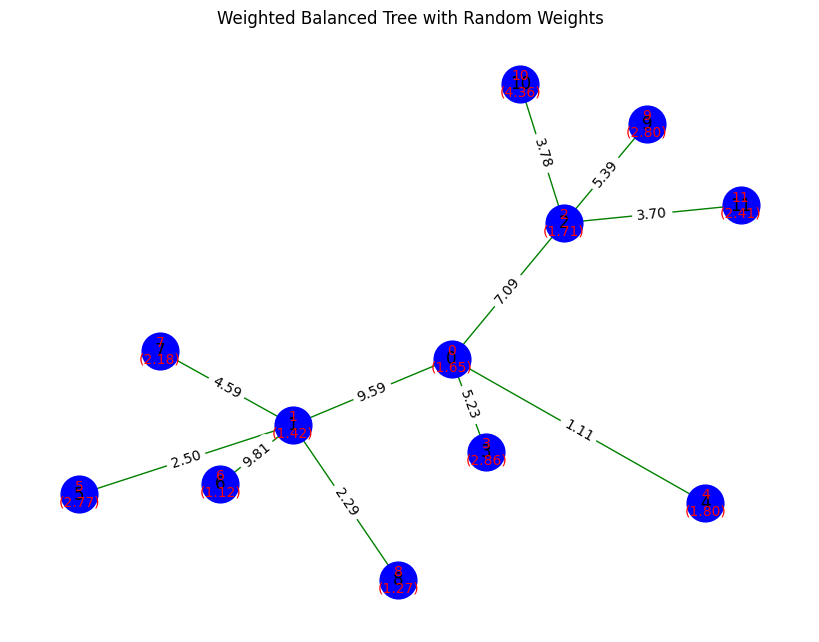

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def generate_weighted_balanced_tree(n, min_degree=3, node_weight_range=(0, 1), edge_weight_range=(0, 1)):
    """
    Generates a balanced tree graph with n nodes, where each node has at least min_degree connections.
    Assigns random weights to nodes and edges.

    Parameters
    ----------
    n : int
        Number of nodes in the tree.
    min_degree : int, optional (default=3)
        Minimum number of connections each node should have.
    node_weight_range : tuple, optional
        Range of weights to assign to nodes (default=(1, 10)).
    edge_weight_range : tuple, optional
        Range of weights to assign to edges (default=(1, 10)).

    Returns
    -------
    tree : networkx.Graph
        A randomly generated balanced tree with n nodes and assigned weights.
    adjacency_matrix : np.ndarray
        The adjacency matrix representing the tree with node and edge weights.
    node_weights : dict
        Dictionary of nodes with assigned weights.
    """

    # Create an empty graph
    tree = nx.Graph()
    tree.add_node(0)
    node_count = 1
    current_level = [0]  # Start from root

    while node_count < n:
        next_level = []
        for node in current_level:
            for _ in range(min_degree):
                if node_count < n:
                    tree.add_node(node_count)
                    tree.add_edge(node, node_count, weight=random.uniform(*edge_weight_range))
                    next_level.append(node_count)
                    node_count += 1
        current_level = next_level

    # Assign random weights to nodes
    node_weights = {node: random.uniform(*node_weight_range) for node in tree.nodes()}

    # Create the adjacency matrix with edge weights
    adjacency_matrix = nx.to_numpy_array(tree, weight='weight')

    # Add node weights to the diagonal
    np.fill_diagonal(adjacency_matrix, list(node_weights.values()))

    # Combine upper and lower triangles since edge weights should be symmetric
    adjacency_matrix = np.triu(adjacency_matrix)

    return tree, adjacency_matrix, node_weights

def visualize_weighted_tree(tree, node_weights, title="Weighted Balanced Tree"):
    """
    Visualizes the generated balanced tree with node and edge weights.

    Parameters
    ----------
    tree : networkx.Graph
        The tree to visualize.
    node_weights : dict
        The node weights for visualization.
    title : str, optional
        The title of the graph plot.
    """
    pos = nx.spring_layout(tree)
    plt.figure(figsize=(8, 6))
    nx.draw(tree, pos, with_labels=True, node_color='blue', edge_color='green', node_size=700, font_size=12)
    edge_labels = nx.get_edge_attributes(tree, 'weight')
    nx.draw_networkx_edge_labels(tree, pos, edge_labels={(u, v): f'{w:.2f}' for u, v, w in tree.edges(data='weight')})
    node_labels = {node: f"{node}\n({node_weights[node]:.2f})" for node in tree.nodes()}
    nx.draw_networkx_labels(tree, pos, labels=node_labels, font_size=10, font_color="red")
    plt.title(title)
    plt.show()

# Example usage
n = 12  # Number of nodes
tree_graph, adj_matrix, node_weights = generate_weighted_balanced_tree(n, min_degree=4, node_weight_range=(1, 5), edge_weight_range=(1, 10))

# Visualize the generated balanced tree with weights
visualize_weighted_tree(tree_graph, node_weights, "Weighted Balanced Tree with Random Weights")





## **2. Tensor Training**

Instead of training a single graph generated by the tensor network using Tensor QAOA, the goal is to find parameters that generalize effectively across multiple graphs. This approach enables the extraction of a reasonable warm-up state.

According to [this reference](https://arxiv.org/pdf/1908.08862), the paper suggests that as long as the problem type remains unchanged, the optimal parameters do not significantly vary, even if the size or shape of the graph is distorted. 

Additionally, during RL QAOA, it has been experimentally confirmed that achieving a state with a sufficiently guaranteed low state, rather than the perfect optimal value of QAOA, leads to improved performance. Therefore, such a warm-up can greatly assist RL QAOA in the learning process.




In [3]:
def generate_complete_graph_with_random_weights(n,
                                               node_weight_min=-3, node_weight_max=3,
                                               edge_weight_min=-3, edge_weight_max=3,
                                               seed=42,
                                               integer_weights=True):
    """
    Generates a complete graph with `n` nodes and assigns random weights
    in the range [-3, 3] (or specified range) to each node and edge.
    """
    rs = np.random.RandomState(seed)
    G = nx.complete_graph(n)  # Create a complete graph

    # Assign random weights to nodes
    for node in G.nodes():
        if integer_weights:
            weight_val = rs.uniform(node_weight_min, node_weight_max+1)
        else:
            weight_val = rs.uniform(node_weight_min, node_weight_max)
        # Store 'node_weight' as a node attribute (not used in RQAOA but for reference)
        G.nodes[node]['node_weight'] = weight_val

    # Assign random weights to edges
    for u, v in G.edges():
        if integer_weights:
            weight_val = rs.uniform(edge_weight_min, edge_weight_max+1)
        else:
            weight_val = rs.uniform(edge_weight_min, edge_weight_max)
        # Store 'weight' as an edge attribute (this is the field used in RQAOA)
        G[u][v]['weight'] = weight_val

    return G


In [4]:
import pennylane as qml
from pennylane import numpy as np
from scipy.optimize import minimize
from RL_QAOA import *
import random
# Define QAOA depth
depth = 1
size = 7
seed = 50

# Generate a QUBO matrix that is challenging for classical QAOA optimization
np.random.seed(seed)
Q = generate_upper_triangular_qubo(size, -3, 3, integer=False)

print(Q)
param_list = []
start = 3

while start <= size:

    graph_list = []

    # 1. Generate 10 different tensor network-friendly quadratic matrices
    # for general training (size ranging from n_c to n)
    for i in range(10):
        tree_graph, adj_matrix, node_weights = generate_weighted_balanced_tree(
            start, min_degree=3, node_weight_range=(-3, 3), edge_weight_range=(-3, 3)
        )
        graph_list.append(adj_matrix)
    # 2. Optimize the generated matrices classically using the SLSQP optimizer
    # to quickly find near-optimal parameters
    qaoa = QAOA_layer(depth=depth, Q=adj_matrix)
    if len(param_list) == 0:
        init_params = np.random.uniform(-0.5, 0.5, 2 * depth)
        print(init_params)
    else:
        init_params = param_list[-1]
        print(init_params)

    index = 0
    def QAOA_tensor_res(param):
        """
        Computes the total expectation value for all generated graphs.

        Args:
            param (np.ndarray): QAOA parameters (gammas and betas).

        Returns:
            float: Sum of expectation values across all graphs.
        """
        res = 0
        for graph in graph_list:
            qaoa = QAOA_layer(depth=depth, Q=np.array(graph))
            @qml.qnode(qaoa.dev)
            def qaoa_expectation(params):
                """
                Quantum node that runs the QAOA circuit and measures the expectation value
                of the cost Hamiltonian.

                Args:
                    params (np.ndarray): Array of QAOA parameters (gammas and betas).

                Returns:
                    float: Expectation value of the cost Hamiltonian.
                """
                qaoa.qaoa_circuit(params)
                return qml.expval(qaoa.ham)
            res += qaoa_expectation(param)
        return res

    # Perform optimization using SLSQP
    bounds = [(-np.pi, np.pi) for _ in init_params]
    result = minimize(QAOA_tensor_res, init_params, method="SLSQP", options={'maxiter': 1000},bounds=bounds)
    param = result.x

    # 3. Extract the optimized parameters and use them as initial values
    # for the next optimization iteration
    print(result)
    param = result.x
    min_cost = result.fun
    param_list.append(param)

    # Print the results
    print("Optimized parameters (gammas and betas):", param)
    print("Minimum cost achieved:", min_cost)

    # Reduce the problem size and repeat the optimization process
    start += 1
param_list.reverse()

[[-0.03239013 -1.63150137 -1.46715646 -0.62202054 -0.73610941  2.97944538
  -0.5508168 ]
 [ 0.          1.56322013 -1.13994391 -0.92075277 -0.8894111  -2.12719886
   2.83598811]
 [ 0.          0.         -1.11845552  2.32920023  1.04743839 -0.65347531
   0.04310474]
 [ 0.          0.          0.          1.01002541 -2.68644785 -1.03765618
  -2.66159016]
 [ 0.          0.          0.          0.          1.39612565 -0.22951394
   2.58797561]
 [ 0.          0.          0.          0.          0.          1.09414301
   2.26833782]
 [ 0.          0.          0.          0.          0.          0.
   2.4978507 ]]
[0.1991026  0.02071031]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -28.803142844695518
       x: [ 1.941e-01 -4.545e-01]
     nit: 9
     jac: [ 3.010e-02  8.460e-03]
    nfev: 34
    njev: 9
Optimized parameters (gammas and betas): [ 0.19411165 -0.45449657]
Minimum cost achieved: -28.803142844695518
[ 0.19411165 -0.45449657]
 message: Optim

# **Comparison of Warm-Up Pretrained Parameters vs. Random Parameters in QAOA**

In the previous step, we generated **warm-up parameters** for the Quadratic Unconstrained Binary Optimization (QUBO) problem using tree graphs and classical optimization techniques. In this section, we compare the performance of these pretrained parameters with randomly initialized parameters to evaluate their effectiveness in QAOA optimization.




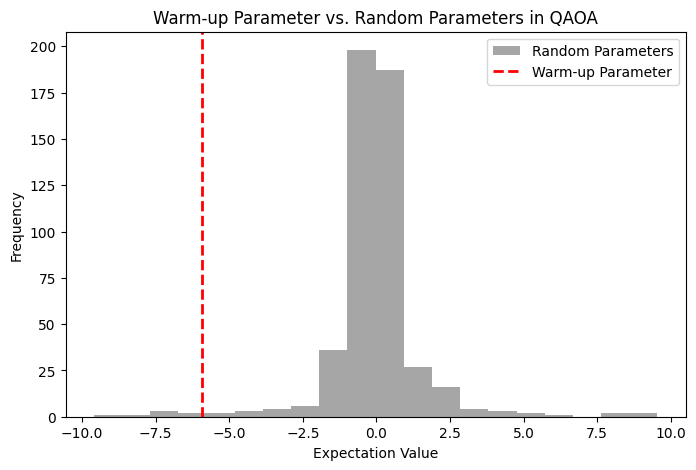

 98.6000% Tensor warm state is better than random state!

Tesnor warm state energy : -5.926189374752983
Mean random state energy : -0.2429233547294309


In [5]:
qaoa = QAOA_layer(depth,Q)
@qml.qnode(qaoa.dev)
def qaoa_expectation(params):
    """
    Quantum node that runs the QAOA circuit and measures the expectation value
    of the cost Hamiltonian.

    Args:
        params (np.ndarray): Array of QAOA parameters (gammas and betas).

    Returns:
        float: Expectation value of the cost Hamiltonian.
    """
    qaoa.qaoa_circuit(params)
    return qml.expval(qaoa.ham)


params = param_list[0]
H = qaoa_expectation(params)

import matplotlib.pyplot as plt

def f(x):
    @qml.qnode(qaoa.dev)
    def qaoa_expectation(params):
        """
        Quantum node that runs the QAOA circuit and measures the expectation value
        of the cost Hamiltonian.

        Args:
            params (np.ndarray): Array of QAOA parameters (gammas and betas).

        Returns:
            float: Expectation value of the cost Hamiltonian.
        """
        qaoa.qaoa_circuit(params)
        return qml.expval(qaoa.ham)
    return qaoa_expectation(x)  # Example function

def visualize_warmup_vs_random(warmup_x, random_x):
    warmup_y = f(warmup_x)
    random_y = np.array([f(x) for x in random_x])

    plt.figure(figsize=(8, 5))

    # Histogram of f(x) results for random x values
    plt.hist(random_y, bins=20, alpha=0.7, color='gray', label='Random Parameters')

    # Marking the f(x) result for warm-up x
    plt.axvline(warmup_y, color='red', linestyle='dashed', linewidth=2, label='Warm-up Parameter')

    # Graph settings
    plt.xlabel('Expectation Value')
    plt.ylabel('Frequency')
    plt.title('Warm-up Parameter vs. Random Parameters in QAOA')
    plt.legend()
    plt.show()
    return warmup_y,random_y
# Example data settings
warmup_x = params # Specific warm-up parameter value
random_x = np.random.uniform(-np.pi, np.pi, (500,2 * depth))  # Sampling 500 random x values from the range [-np.pi, np.pi]

warmup_y,random_y = visualize_warmup_vs_random(warmup_x, random_x)

prob = 0
mean_rand_H = 0
for i in range(len(random_y)):
    H_random = random_y[i]
    H = warmup_y
    if H_random>H:
        prob+=1
    mean_rand_H += H_random

mean_rand_H = mean_rand_H/100
prob = prob/len(random_y)*100
print(f' {prob:.4f}% Tensor warm state is better than random state!\n')

print(f'Tesnor warm state energy : {warmup_y}')
print(f'Mean random state energy : {mean_rand_H}')


# **Comparison of RL-QAOA with Warm-Up State vs. Random Initialization**

In this session, we aim to compare the performance of **Reinforcement Learning-based QAOA (RL-QAOA)** under two different initialization strategies:

1. **Warm-Up State Initialization:**  
   - We leverage the pretrained parameters obtained from our previous warm-up process using tensor-network-friendly graphs.
   
2. **Random Initialization:**  
   - The RL-QAOA starts with randomly initialized parameters without any prior knowledge.



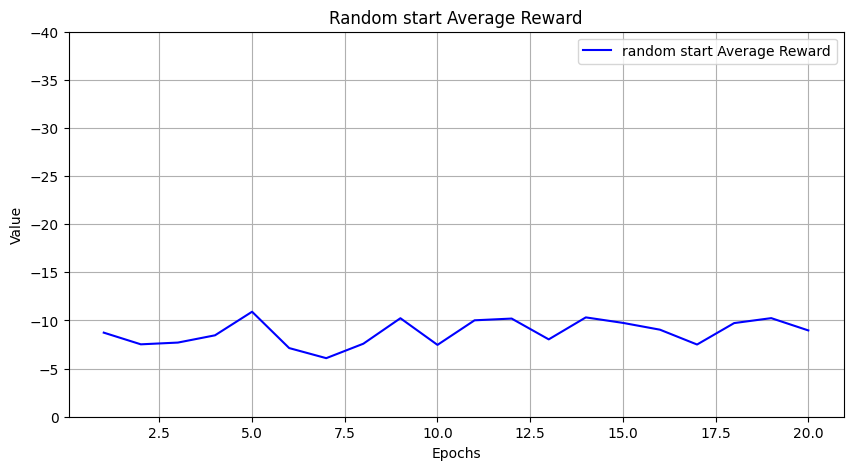
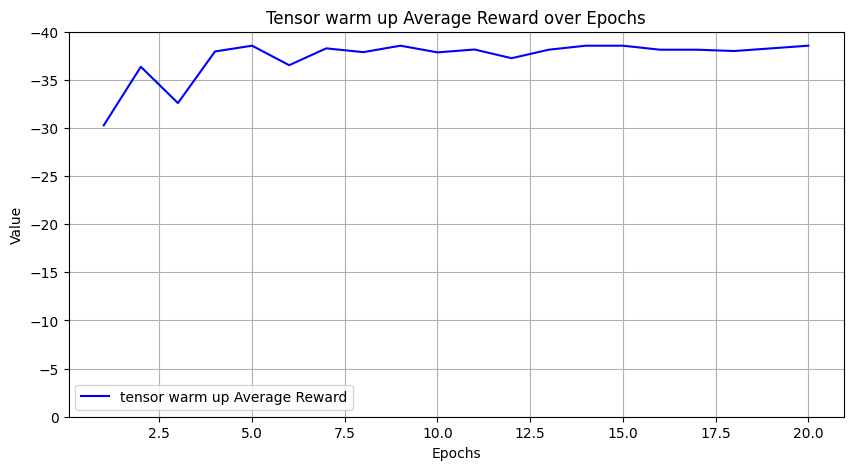
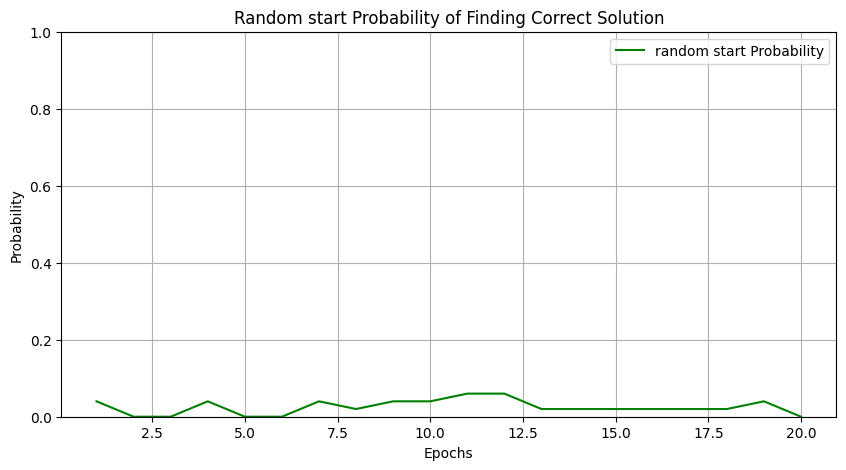
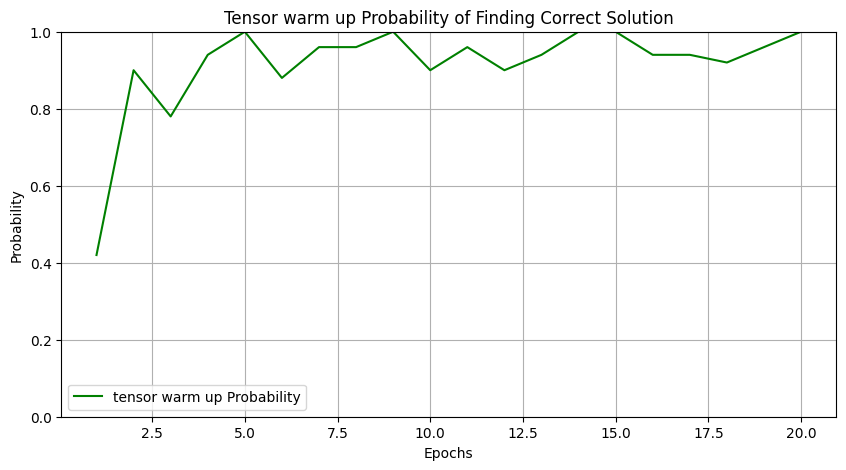


In [6]:
import pennylane as qml  # Importing PennyLane for quantum computing
from pennylane import numpy as np  # Importing PennyLane's NumPy for compatibility
import torch  # Importing PyTorch for potential machine learning applications
import torch.nn as nn  # Importing PyTorch's neural network module
import copy  # Importing copy module for deep copying objects
import itertools  # Importing itertools for combinatorial operations
from tqdm import tqdm  # Importing tqdm for progress tracking
from scipy.optimize import minimize
import random
import pennylane as qml

import copy
import itertools
import torch
import pennylane as qml






class TreeNode:
    def __init__(self, key, value):
        """
        Initializes a tree node.
        :param key: The unique identifier for the node.
        :param value: The data associated with the node.
        """
        self.key = key  # Node's unique key
        self.value = value  # Node's stored value
        self.children = {}  # Dictionary to store child nodes (key -> TreeNode mapping)

    def __repr__(self):
        """
        Returns a string representation of the node.
        """
        return f"TreeNode({self.key}: {self.value})"


class Tree:
    def __init__(self, root_key, root_value):
        """
        Initializes a tree with a root node.
        :param root_key: The unique key for the root node.
        :param root_value: The data associated with the root node.
        """
        self.root = TreeNode(root_key, root_value)  # Create the root node
        self.state = self.root  # Set the current state to the root node
        self.node_num = 0
    def has_child(self, key):
        """
        Checks if the current state (node) has a child with the given key.
        :param key: The key of the child node to check.
        :return: True if the child exists, False otherwise.
        """
        return key in self.state.children  # Check if the key exists in the children dictionary

    def move(self, key):
        """
        Moves the current state to a child node if it exists.
        :param key: The key of the child node to move to.
        :raises ValueError: If the child does not exist.
        """
        if self.has_child(key):  # If the child exists, move to it
            self.state = self.state.children[key]

        else:
            raise ValueError(f"Error: No child with key '{key}' exists.")  # Raise an error if child doesn't exist

    def create(self, key, value):
        """
        Creates a new child node under the current state if the key does not already exist.
        :param key: The key of the new child node.
        :param value: The value to store in the new node.
        :raises ValueError: If the key already exists.
        """
        if not self.has_child(key):  # If the child does not exist, create it
            new_node = TreeNode(key, value)
            self.state.children[key] = new_node  # Add the new node to the children dictionary
            self.node_num +=1
        else:
            raise ValueError(f"Error: Child '{key}' already exists.")  # Raise an error if child already exists

    def reset_state(self):
        """
        Resets the current state back to the root node.
        """
        self.state = self.root  # Set state back to the root node


    def display_tree(self, node=None, level=0):
        """
        Recursively prints the structure of the tree.
        :param node: The node to start printing from (default is the root node).
        :param level: The indentation level for printing the tree hierarchy.
        """
        if node is None:  # If no node is provided, start from the root
            node = self.root
        print("  " * level + f"{node.key}: {node.value}")  # Print the current node with indentation
        for child in node.children.values():  # Iterate through all child nodes
            self.display_tree(child, level + 1)  # Recursively print child nodes with increased indentation



class RL_QAOA:
    """
    A reinforcement learning-based approach to solving QAOA (Quantum Approximate Optimization Algorithm)
    for quadratic unconstrained binary optimization (QUBO) problems.

    Parameters
    ----------
    Q : np.ndarray
        QUBO matrix representing the optimization problem.

    n_c : int
        The threshold number of nodes at which classical brute-force optimization is applied.

    init_paramter : np.ndarray
        Initial parameters for the QAOA circuit.

    b_vector : np.ndarray
        The beta vector used in reinforcement learning to guide edge selection.

    QAOA_depth : int
        Depth of the QAOA circuit, representing the number of layers.

    gamma : float, default=0.99
        Discount factor used in reinforcement learning.

    learning_rate_init : float, default=0.001
        Initial learning rate for the Adam optimizer.

    Attributes
    ----------
    qaoa_layer : QAOA_layer
        Instance of the QAOA layer with specified depth and QUBO matrix.

    optimizer : AdamOptimizer
        Adam optimizer instance to optimize QAOA parameters.

    same_list : list
        List of edges that should have the same value.

    diff_list : list
        List of edges that should have different values.

    node_assignments : dict
        Tracks assigned values to the nodes.

    """

    def __init__(self, Q, n_c, init_paramter, b_vector, QAOA_depth, gamma=0.99, learning_rate_init=[0.01,0.05]):
        self.Q = Q
        self.n_c = n_c
        self.param = init_paramter
        self.b = b_vector
        self.p = QAOA_depth
        self.qaoa_layer = QAOA_layer(QAOA_depth, Q)
        self.gamma = gamma
        self.optimzer = AdamOptimizer([init_paramter, b_vector], learning_rate_init=learning_rate_init)
        self.lr = learning_rate_init
        self.tree = Tree('root',None)
        self.tree_grad = Tree('root',None)

    def RL_QAOA(self, episodes, epochs, correct_ans=None):
        self.avg_values = []
        self.min_values = []
        self.prob_values = []
        self.best_states = []
        self.best_same_lists = []
        self.best_diff_lists = []

        """
        Performs the reinforcement learning optimization process with progress tracking.

        Parameters
        ----------
        episodes : int
            Number of Monte Carlo trials for the optimization.

        epochs : int
            Number of optimization iterations to update parameters.

        correct_ans : float, optional
            The correct optimal solution (if available) to calculate success probability.
        """

        for j in range(epochs):

            if self.lr[0] != 0:
                num = self.tree.node_num

                self.tree = Tree('root',None)
                self.tree.node_num = num
                self.tree_grad = Tree('root',None)
                self.tree_grad.node_num = num
            value_list = []
            state_list = []
            QAOA_diff_list = []
            beta_diff_list = []
            same_lists = []
            diff_lists = []

            if correct_ans is not None:
                prob = 0

            # Progress bar for episodes within the current epoch
            for i in tqdm(range(episodes), desc=f'Epoch {j + 1}/{epochs}', unit=' episode'):
                QAOA_diff, beta_diff, value, final_state, same_list, diff_list = self.rqaoa_execute()
                value_list.append(value)
                state_list.append(final_state)
                same_lists.append(same_list)
                diff_lists.append(diff_list)
                QAOA_diff_list.append(QAOA_diff)
                beta_diff_list.append(beta_diff)

                if correct_ans is not None and correct_ans - 0.01 <= value <= correct_ans + 0.01:
                    prob += 1

            # Compute softmax rewards and normalize

            batch_mean = (np.array(value_list) - np.mean(value_list))
            #batch_plus = np.where(batch_mean < 0, batch_mean, 0)
            #softmaxed_rewards = signed_softmax_rewards(batch_plus, beta=15)*episodes
            for index, val in enumerate(batch_mean):
                QAOA_diff_list[index] *= -batch_mean[index]
                beta_diff_list[index] *= -batch_mean[index]

            # Compute parameter updates
            QAOA_diff_sum = np.mean(QAOA_diff_list, axis=0)
            beta_diff_sum = np.mean(beta_diff_list, axis=0)
            value_sum = np.mean(value_list)
            min_value = np.min(value_list)  # Find the lowest reward value
            min_index = np.argmin(value_list)  # Index of lowest reward value
            # Store values
            self.avg_values.append(value_sum)
            self.min_values.append(min_value)
            if correct_ans is not None:
                prob /= episodes
            self.prob_values.append(prob)
            self.best_states.append(state_list[min_index])
            self.best_same_lists.append(same_lists[min_index][:3])  # Store top 3 same list elements
            self.best_diff_lists.append(diff_lists[min_index][:3])  # Store top 3 diff list elements

            # Print optimization progress
            if j % 5 == 0:
                if correct_ans is not None:
                    print(f'  Probability of finding correct solution: {prob:.4f}')
                print(f'  Average reward: {value_sum}')
                print(f'  Lowest reward obtained: {min_value}')
                print(f'  Best state at lowest value: {self.best_states[-1]}')
                #print(f'  Top 3 same constraints: {self.best_same_lists[-1]}')
                #print(f'  Top 3 different constraints: {self.best_diff_lists[-1]}')


            # Update parameters using the Adam optimizer
            update = self.optimzer.get_updates([QAOA_diff_sum, beta_diff_sum])
            self.param += np.array(update[0])
            self.b += np.array(update[1])

    def rqaoa_execute(self, cal_grad=True):
        """
        Executes the RQAOA algorithm by iteratively reducing the QUBO problem.

        Parameters
        ----------
        cal_grad : bool, default=True
            Whether to calculate the gradient.

        Returns
        -------
        tuple or float
            If cal_grad is True, returns gradients, value, and final state.
            Otherwise, returns only the final value.
        """

        Q_init = copy.deepcopy(self.Q)
        Q_action = copy.deepcopy(self.Q)
        self.same_list = []
        self.diff_list = []
        self.node_assignments = {}
        self.edge_expectations = []
        self.edge_expectations_grad = []
        self.policys = []

        QAOA_diff_list = []
        beta_diff_list = []
        index = 0




        while Q_init.shape[0] > self.n_c:
            if self.b.ndim == 1:
                self.beta = self.b
            else:
                self.beta = self.b[index]


            if self.tree.state.value is None:
                edge_expectations = self._qaoa_edge_expectations(
                    Q_init, [i for i in range(self.p * index * 2, self.p * index * 2 + 2 * self.p)]
                )
                self.tree.state.value = edge_expectations
            else:
                edge_expectations = self.tree.state.value
            selected_edge_idx, policy, edge_res = self._select_edge_to_cut(Q_action, Q_init, edge_expectations)

            if cal_grad:
                """ edge_res_grad = self._qaoa_edge_expectations_gradient(
                    Q_init, [i for i in range(self.p * index * 2, self.p * index * 2 + 2 * self.p)], selected_edge_idx
                ) """
                if self.lr[0] != 0:
                    if self.tree_grad.state.value is None:
                        edge_res_grad = self._qaoa_edge_expectations_gradients(
                            Q_init, [i for i in range(self.p * index * 2, self.p * index * 2 + 2 * self.p)]
                        )
                        self.tree_grad.state.value = edge_res_grad
                        self._tree_action(self.tree_grad, edge_expectations,selected_edge_idx,Q_init)

                    else:
                        edge_res_grad = self.tree_grad.state.value
                        self._tree_action(self.tree_grad, edge_expectations,selected_edge_idx,Q_init)
                else:
                    pass


                if self.lr[0] != 0:
                    QAOA_diff = self._compute_log_pol_diff(
                        selected_edge_idx, Q_action, edge_res, edge_res_grad, policy
                    ) * self.gamma ** (Q_init.shape[0] - index)

                else:
                    QAOA_diff = np.zeros_like(self.param)

                beta_diff = self._compute_grad_beta(selected_edge_idx, Q_action, policy, edge_res) * self.gamma ** (Q_init.shape[0] - index)
                QAOA_diff_list.append(QAOA_diff)
                beta_diff_list.append(beta_diff)

            Q_init, Q_action = self._cut_edge(selected_edge_idx, edge_res, Q_action, Q_init)
            index += 1

        self.tree.reset_state()
        self.tree_grad.reset_state()
        # Solve smaller problem using brute force
        self._brute_force_optimal(Q_init)
        Value = self._state_energy(np.array(self.node_assignments), self.Q)

        # Copy lists to preserve their state
        same_list_copy = copy.deepcopy(self.same_list)
        diff_list_copy = copy.deepcopy(self.diff_list)

        if self.n_c != self.Q.shape[0]:
            QAOA_diff = np.sum(QAOA_diff_list, axis=0)
        else:
            QAOA_diff = None
        if self.n_c != self.Q.shape[0]:
            if self.beta.ndim == 1:
                beta_diff = np.sum(beta_diff_list, axis=0)
            else:
                beta_diff = np.stack(beta_diff_list, axis=0)
        else:
            beta_diff = None



        # If gradient calculation is enabled, return additional data
        if cal_grad:
            return QAOA_diff, beta_diff, Value, np.array(self.node_assignments), same_list_copy, diff_list_copy
        else:
            return Value

    def _select_edge_to_cut(self, Q_action, Q_init, edge_expectations):
        """
        Selects an edge to be cut based on a softmax probability distribution over interactions.

        Parameters
        ----------
        Q_action : np.ndarray
            Current QUBO matrix tracking active nodes.

        Q_init : np.ndarray
            Initial QUBO matrix.

        edge_expectations : list
            Expectation values of ZZ interactions for all edges.

        Returns
        -------
        tuple
            Index of selected edge, probability distribution, expectation values.
        """
        action_space = self._action_space(Q_action)

        try:
            value = abs(np.array(edge_expectations))

            value = value - np.amax(value)
            interactions = abs(np.array(edge_expectations)) * self.beta[action_space]
            interactions -= np.amax(interactions)
        except:
            print(abs(np.array(edge_expectations)), self.b[action_space])
            raise ValueError("Invalid input", action_space, abs(np.array(edge_expectations)))
        interactions = np.exp(interactions)
        probabilities = interactions/np.sum(interactions)
        #probabilities = torch.softmax(torch.tensor(interactions), dim=0).numpy()
        selected_edge_idx = np.random.choice(len(probabilities), p=probabilities)

        return selected_edge_idx, probabilities, edge_expectations
    def _compute_log_pol_diff(self, idx, Q_action, edge_expectations, edge_expectations_grad, policy):
        """
        Computes the gradient of the log-policy for the selected edge.

        Parameters
        ----------
        idx : int
            Index of the selected edge.

        Q_action : np.ndarray
            QUBO matrix representing the current optimization problem.

        edge_expectations : list
            Expectation values of ZZ interactions for all edges.

        edge_expectations_grad : list
            Gradient of the expectation values of ZZ interactions for all edges.

        policy : list
            Probability distribution over edges for selection.

        Returns
        -------
        np.array
            The computed gradient of the log-policy.
        """
        action_space = self._action_space(Q_action)
        betas = self.beta[action_space]
        gather = np.zeros_like(policy)

        # Compute the weighted sum of policy and betas
        for i in range(len(edge_expectations_grad)):
            gather[i] += policy[i] * betas[i]

        diff_log_pol = betas[idx] * np.sign(edge_expectations[idx]) * edge_expectations_grad[idx]

        # Adjust the gradient with respect to policy values
        for i in range(len(gather)):
            if gather[i]:
                diff_log_pol -= gather[i] * np.sign(edge_expectations[i]) * edge_expectations_grad[i]

        return np.array(diff_log_pol)

    def _compute_log_pol_diff_idx(self, idx, Q_action, edge_expectations, grad, policy):
        """
        Computes the gradient of the log-policy for a given edge selection.

        Parameters
        ----------
        idx : int
            Index of the selected edge.

        Q_action : np.ndarray
            QUBO matrix representing the current optimization problem.

        edge_expectations : list
            Expectation values of ZZ interactions for all edges.

        grad : float
            Gradient value corresponding to the selected edge.

        policy : list
            Probability distribution over edges for selection.

        Returns
        -------
        np.array
            The computed gradient of the log-policy for the selected edge.
        """
        action_space = self._action_space(Q_action)
        betas = self.beta[action_space]

        diff_log_pol = betas[idx] * np.sign(edge_expectations[idx]) * grad - policy[idx] * betas[idx] * np.sign(edge_expectations[idx]) * grad
        return np.array(diff_log_pol)

    def _compute_grad_beta(self, idx, Q_action, policy, edge_expectations):
        """
        Computes the gradient of the beta parameter.

        Parameters
        ----------
        idx : int
            Index of the selected edge.

        Q_action : np.ndarray
            QUBO matrix representing the current optimization problem.

        policy : list
            Probability distribution over edges for selection.

        edge_expectations : list
            Expectation values of ZZ interactions for all edges.

        Returns
        -------
        np.array
            The computed gradient of the beta parameter.
        """
        abs_expectations = abs(np.array(edge_expectations))
        action_space = self._action_space(Q_action)

        betas_idx = action_space
        grad = np.zeros(len(self.beta))

        grad[betas_idx[idx]] += abs_expectations[idx]

        # Compute gradient by adjusting with policy values
        for i in range(len(action_space)):
            grad[betas_idx[i]] -= policy[i] * abs_expectations[i]

        return np.array(grad)

    def _cut_edge(self, selected_edge_idx, expectations, Q_action, Q_init):
        """
        Cuts the selected edge and returns the reduced QUBO matrix along with a matrix of the same size
        where the corresponding node values are set to zero.

        Parameters
        ----------
        selected_edge_idx : int
            Index of the selected edge to be cut.

        expectations : list
            Expectation values of ZZ interactions for all edges.

        Q_action : np.ndarray
            Current QUBO matrix tracking active nodes.

        Q_init : np.ndarray
            Initial QUBO matrix.

        Returns
        -------
        tuple
            Reduced QUBO matrix and an updated QUBO matrix with the selected nodes set to zero.
        """
        edge_list = [(i, j) for i in range(Q_init.shape[0]) for j in range(Q_init.shape[0]) if Q_init[i, j] != 0 and i != j]
        edge_to_cut = edge_list[selected_edge_idx]
        edge_to_cut = sorted(edge_to_cut)

        expectation = expectations[selected_edge_idx]

        i, j = edge_to_cut[0], edge_to_cut[1]

        for key in dict(sorted(self.node_assignments.items(), key=lambda item: item[0])):
            if i >= key:
                i += 1
            if j >= key:
                j += 1

        self.node_assignments[i] = 1

        new_Q, Q_action = reduce_hamiltonian(Q_init, edge_to_cut[0], edge_to_cut[1], self.node_assignments, int(np.sign(expectation)))
        if expectation > 0:
            self.same_list.append((i, j))
        else:
            self.diff_list.append((i, j))

        self._tree_action(self.tree, expectations, selected_edge_idx, Q_init)
        return new_Q, Q_action


    def _tree_action(self,tree, expectations,selected_edge_idx,Q_init):
        edge_list = [(i, j) for i in range(Q_init.shape[0]) for j in range(Q_init.shape[0]) if Q_init[i, j] != 0 and i != j]
        edge_to_cut = edge_list[selected_edge_idx]
        edge_to_cut = sorted(edge_to_cut)

        expectation = expectations[selected_edge_idx]

        i, j = edge_to_cut[0], edge_to_cut[1]

        for key in dict(sorted(self.node_assignments.items(), key=lambda item: item[0])):
            if i >= key:
                i += 1
            if j >= key:
                j += 1

        if expectation > 0:
            self.key = f'({i},{j})'
            if tree.has_child(self.key):
                tree.move(self.key)

            else:
                tree.create(self.key,None)
                tree.move(self.key)
        else:
            self.key = f'({-i},{-j})'
            if tree.has_child(self.key):
                tree.move(self.key)
            else:
                tree.create(self.key,None)
                tree.move(self.key)


    def _action_space(self, Q_action):
        """
        Maps the edges in the reduced graph to their original positions in the full graph.

        This function is used to track which edges in the reduced graph correspond to the original
        graph's edges after node elimination. When a node is removed, the edge indices in the
        reduced graph will shift, and this function helps maintain consistency with the original
        edge indexing.

        Example:
        --------
        Suppose the original graph has nodes [1, 2, 3, 4, 5] with edges:
            (1,2), (2,3), (3,4), (4,5)

        If node 3 is removed, the reduced graph has edges:
            (1,2), (4,5)

        The reduced graph will renumber nodes as:
            (1,2) -> (1,2), (4,5) -> (2,3)

        This function ensures the correct mapping to the original graph using `Q_action`.

        Parameters
        ----------
        Q_action : np.ndarray
            The original QUBO matrix with node elimination information, used to track active nodes.

        Returns
        -------
        list
            A list of indices indicating which edges in the reduced graph correspond to the original
            graph structure.
        """
        action_space_list = []
        index = 0  # Tracks the original edge indices

        for i in range(Q_action.shape[0]):
            for j in range(Q_action.shape[0]):
                if i != j:  # Avoid self-loops
                    if Q_action[i, j] != 0:  # Check if the edge exists in the original graph
                        action_space_list.append(index)  # Store the original edge index
                    index += 1  # Increment index for original edge mapping

        return action_space_list

    def _qaoa_edge_expectations(self, Q, idx):
        """
        Computes the expectation values of ZZ interactions for each edge in the given QUBO matrix.

        Parameters
        ----------
        Q : np.ndarray
            The QUBO matrix representing the optimization problem.

        idx : int
            Index for selecting the QAOA parameters.

        Returns
        -------
        list
            A list of expectation values for ZZ interactions of the edges in the QUBO matrix.
        """
        self.qaoa_layer = QAOA_layer(self.p, Q)

        @qml.qnode(self.qaoa_layer.dev)
        def circuit(param):
            self.qaoa_layer.qaoa_circuit(param)
            return [qml.expval(qml.PauliZ(i) @ qml.PauliZ(j))
                    for i in range(Q.shape[0])
                    for j in range(Q.shape[0])
                    if Q[i, j] != 0 and i != j]

        return circuit(self.param[idx])

    def _qaoa_edge_expectations_gradients(self, Q, idx):
        """
        Computes the gradients of the expectation values of ZZ interactions for each edge.

        Parameters
        ----------
        Q : np.ndarray
            The QUBO matrix representing the optimization problem.

        idx : int
            Index for selecting the QAOA parameters.

        Returns
        -------
        list
            A list of gradient values for the expectation values of ZZ interactions.
        """
        self.qaoa_layer = QAOA_layer(self.p, Q)
        res = []

        @qml.qnode(self.qaoa_layer.dev)
        def circuit(params, i, j):
            self.qaoa_layer.qaoa_circuit(params[idx])
            return qml.expval(qml.PauliZ(i) @ qml.PauliZ(j))

        # Compute gradients for each valid edge
        for i in range(Q.shape[0]):
            for j in range(Q.shape[0]):
                if Q[i, j] != 0 and i != j:
                    gradients = qml.grad(circuit)(self.param, i, j)
                    res.append(gradients)

        return res

    def _qaoa_edge_expectations_gradient(self, Q, idx, index):
        """
        Computes the gradient of a specific ZZ interaction expectation value for a selected edge.

        Parameters
        ----------
        Q : np.ndarray
            The QUBO matrix representing the optimization problem.

        idx : int
            Index for selecting the QAOA parameters.

        index : int
            The specific edge index to compute the gradient for.

        Returns
        -------
        float
            The gradient of the ZZ expectation value for the selected edge.
        """
        self.qaoa_layer = QAOA_layer(self.p, Q)
        number = 0

        @qml.qnode(self.qaoa_layer.dev)
        def circuit(params, i, j):
            self.qaoa_layer.qaoa_circuit(params[idx])
            return qml.expval(qml.PauliZ(i) @ qml.PauliZ(j))

        for i in range(Q.shape[0]):
            for j in range(Q.shape[0]):
                if Q[i, j] != 0 and i != j:
                    if number == index:
                        gradients = qml.grad(circuit)(self.param, i, j)
                        return gradients
                    number += 1

    def _brute_force_optimal(self, Q):
        """
        Finds the optimal solution using brute force when the graph size is small.

        Parameters
        ----------
        Q : np.ndarray
            The reduced QUBO matrix.

        Updates
        -------
        self.node_assignments : dict
            Stores the optimal node assignments obtained through brute-force search.
        """
        n = self.Q.shape[0]
        configs = list(itertools.product([-1, 1], repeat=n))
        best_value = np.inf
        res_node = None

        # Find all valid combinations considering the same and different constraints
        comb_list = get_case(self.same_list, self.diff_list,n)

        for comb in comb_list:
            value = self._state_energy(np.array(comb), self.Q)
            if value < best_value:
                best_value = value
                res_node = copy.copy(comb)

        # Store the optimal assignment
        self.node_assignments = res_node

    def _state_energy(self, state, Q):
        """
        Computes the energy of a given state based on the QUBO matrix.

        Parameters
        ----------
        state : np.ndarray
            Binary state vector (e.g. [-1, 1, -1, 1]).

        Q : np.ndarray
            The QUBO matrix representing the optimization problem.

        Returns
        -------
        float
            The computed energy value of the given state.
        """
        # Create an identity matrix of the same size
        identity_matrix = np.eye(Q.shape[0], dtype=bool)

        # Remove diagonal elements from the QUBO matrix to isolate interactions
        interaction = np.where(identity_matrix, 0, Q)
        diagonal_elements = np.diag(Q)

        # Compute the energy using the QUBO formulation
        value = diagonal_elements @ state + state.T @ interaction @ state
        return value


def cut_k_matrices_randomly(matrix, m, k):
    n = matrix.shape[0]
    if m >= n:
        raise ValueError("m must be smaller than the size of the matrix")

    selected_subsets = []
    remaining_indices = list(range(n))
    combinations_list = generate_combinations(n, m)
    random_indices = random.sample(range(len(combinations_list)), k)
    indices = [combinations_list[i] for i in random_indices]
    for indice in indices:
        matrix_copy = copy.deepcopy(matrix)
        remaining_indices = list(range(n))
        remaining_indices = sorted(set(remaining_indices) - set(indice))
        reduced_matrix = matrix_copy[np.ix_(remaining_indices, remaining_indices)]
        selected_subsets.append(reduced_matrix)

    return selected_subsets

def generate_combinations(n, m):
    return list(combinations(range(n), m))



def generate_upper_triangular_qubo(size, low=-10, high=10, integer=True, seed=None):
    """
    Generates an upper-triangular QUBO (Quadratic Unconstrained Binary Optimization) matrix.

    Args:
        size (int): The number of variables (size of the QUBO matrix).
        low (int/float): Minimum value of the random elements.
        high (int/float): Maximum value of the random elements.
        integer (bool): If True, generates integer values; otherwise, generates float values.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        np.ndarray: An upper-triangular QUBO matrix of the specified size.
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate random values for the upper triangular part including diagonal
    if integer:
        Q = np.random.randint(low, high, (size, size))
    else:
        Q = np.random.uniform(low, high, (size, size))

    # Keep only the upper triangle values (including diagonal), set lower triangle to zero
    Q = np.triu(Q)


    # Ensure diagonal values are positive (bias terms)
    np.fill_diagonal(Q,np.diagonal(Q))


    return Q

class AdamOptimizer:
    """
    Stochastic gradient descent optimizer using the Adam optimization algorithm.

    Note: All default values are based on the original Adam paper.

    Parameters
    ----------
    params : list
        A concatenated list containing coefs_ and intercepts_ in the MLP model.
        Used for initializing velocities and updating parameters.

    learning_rate_init : float, default=0.001
        The initial learning rate used to control the step size in updating the weights.

    beta_1 : float, default=0.9
        Exponential decay rate for estimates of the first moment vector, should be in [0, 1).

    beta_2 : float, default=0.999
        Exponential decay rate for estimates of the second moment vector, should be in [0, 1).

    epsilon : float, default=1e-8
        A small value to ensure numerical stability and avoid division by zero.

    amsgrad : bool, default=False
        Whether to use the AMSGrad variant of Adam.

    Attributes
    ----------
    learning_rate : float
        The current learning rate after applying bias correction.

    t : int
        The optimization step count (timestep).

    ms : list
        First moment vectors (moving average of gradients).

    vs : list
        Second moment vectors (moving average of squared gradients).

    max_vs : list
        Maximum of past squared gradients used in AMSGrad.

    References
    ----------
    Kingma, Diederik, and Jimmy Ba.
    "Adam: A method for stochastic optimization."
    arXiv preprint arXiv:1412.6980 (2014).
    """

    def __init__(self, params, learning_rate_init=0.001, beta_1=0.9,
                 beta_2=0.999, epsilon=1e-8, amsgrad=False):

        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        # Initialize learning rate as an array if provided, else a scalar
        if isinstance(learning_rate_init, float):
            self.learning_rate_init = np.ones(len(params)) * learning_rate_init
        else:
            self.learning_rate_init = np.array(learning_rate_init)

        self.t = 0  # Timestep initialization
        self.ms = [np.zeros_like(param) for param in params]  # First moment vector (m)
        self.vs = [np.zeros_like(param) for param in params]  # Second moment vector (v)
        self.amsgrad = amsgrad
        self.max_vs = [np.zeros_like(param) for param in params]  # For AMSGrad correction

    def get_updates(self, grads):
        """
        Computes the parameter updates based on the provided gradients.

        Parameters
        ----------
        grads : list
            Gradients with respect to coefs_ and intercepts_ in the model.

        Returns
        -------
        updates : list
            The values to be added to params for optimization.
        """
        self.t += 1  # Increment timestep

        # Update biased first moment estimate (m)
        self.ms = [self.beta_1 * m + (1 - self.beta_1) * grad
                   for m, grad in zip(self.ms, grads)]

        # Update biased second moment estimate (v)
        self.vs = [self.beta_2 * v + (1 - self.beta_2) * (grad ** 2)
                   for v, grad in zip(self.vs, grads)]

        # Update maximum second moment for AMSGrad if enabled
        self.max_vs = [np.maximum(v, max_v) for v, max_v in zip(self.vs, self.max_vs)]

        # Compute bias-corrected learning rate
        self.learning_rate = (self.learning_rate_init *
                              np.sqrt(1 - self.beta_2 ** self.t) /
                              (1 - self.beta_1 ** self.t))

        # Compute update step based on AMSGrad condition
        if self.amsgrad:
            updates = [lr * m / (np.sqrt(max_v) + self.epsilon)
                       for lr, m, max_v in zip(self.learning_rate, self.ms, self.max_vs)]
        else:
            updates = [lr * m / (np.sqrt(v) + self.epsilon)
                       for lr, m, v in zip(self.learning_rate, self.ms, self.vs)]

        return updates


class QAOA_layer:

    def __init__(self, depth, Q):
        """
        A class to represent a layer of a Quantum Approximate Optimization Algorithm (QAOA).

        Parameters
        ----------
        depth : int
            The number of QAOA layers (depth of the circuit).

        Q : np.ndarray
            The QUBO matrix representing the quadratic unconstrained binary optimization problem.

        Attributes
        ----------
        Q : np.ndarray
            The QUBO matrix.

        p : int
            The depth of the QAOA circuit.

        ham : qml.Hamiltonian
            The cost Hamiltonian for the given QUBO problem.

        dev : qml.device
            The quantum device used for simulation.

        """
        self.Q = Q  # Store the QUBO matrix
        self.p = depth  # Store the QAOA depth
        self.ham = self.prepare_cost_hamiltonian()  # Prepare the cost Hamiltonian based on QUBO matrix
        self.dev = qml.device("default.qubit", wires=Q.shape[0])  # Quantum device with qubits equal to Q size

    def qaoa_circuit(self, params):
        """
        Constructs the QAOA circuit based on given parameters.

        Parameters
        ----------
        params : list
            A list containing gamma and beta values for parameterized QAOA layers.
        """
        n = self.Q.shape[0]  # Number of qubits based on QUBO matrix size
        gammas = params[:self.p]  # Extract gamma parameters
        betas = params[self.p:]  # Extract beta parameters

        # Apply Hadamard gates to all qubits for uniform superposition
        for i in range(n):
            qml.Hadamard(wires=i)

        # Apply QAOA layers consisting of cost and mixer Hamiltonians
        for layer in range(self.p):
            self.qubo_cost(gammas[layer])
            self.mixer(betas[layer])

    def qubo_cost(self, gamma):
        """
        Implements the cost Hamiltonian evolution for the QUBO problem.

        Parameters
        ----------
        gamma : float
            Parameter for cost Hamiltonian evolution.
        """
        n = self.Q.shape[0]
        for i in range(n):
            for j in range(n):
                if self.Q[i, j] != 0:
                    if i == j:
                        qml.RZ(2 * gamma * float(self.Q[i, j]), wires=i)
                    else:
                        qml.CNOT(wires=[i, j])
                        qml.RZ(2 * gamma * float(self.Q[i, j]), wires=j)
                        qml.CNOT(wires=[i, j])

    def mixer(self, beta):
        """
        Implements the mixer Hamiltonian for QAOA.

        Parameters
        ----------
        beta : float
            Parameter for mixer Hamiltonian evolution.
        """
        for i in range(self.Q.shape[0]):
            qml.RX(2 * beta, wires=i)

    def prepare_cost_hamiltonian(self):
        """
        Constructs the cost Hamiltonian for the QUBO problem.

        Returns
        -------
        qml.Hamiltonian
            The constructed cost Hamiltonian.
        """
        n = self.Q.shape[0]
        coeffs = []
        ops = []

        for i in range(n):
            for j in range(n):
                if self.Q[i, j] != 0:
                    if i == j:
                        coeffs.append(self.Q[i, j])
                        ops.append(qml.PauliZ(i))
                    else:
                        coeffs.append(self.Q[i, j])
                        ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

        return qml.Hamiltonian(coeffs, ops)



def add_zero_row_col(matrix, m):
    """
    Adds a new row and column filled with zeros at the specified position
    in an n x n matrix, resulting in an (n+1) x (n+1) matrix.

    Args:
        matrix (np.array): The original n x n matrix.
        m (int): The index (0-based) where the new row and column will be inserted.

    Returns:
        np.array: The expanded (n+1) x (n+1) matrix with the new row and column filled with zeros.
    """
    n = matrix.shape[0]  # Get the size of the original matrix

    # Create a new (n+1)x(n+1) matrix initialized with zeros
    new_matrix = np.zeros((n + 1, n + 1))

    # Copy the top-left submatrix (before row m and column m)
    new_matrix[:m, :m] = matrix[:m, :m]

    # Copy the top-right submatrix (after column m)
    new_matrix[:m, m+1:] = matrix[:m, m:]

    # Copy the bottom-left submatrix (after row m)
    new_matrix[m+1:, :m] = matrix[m:, :m]

    # Copy the bottom-right submatrix (after row m and column m)
    new_matrix[m+1:, m+1:] = matrix[m:, m:]

    # The new row (index m) and column (index m) remain zeros by default

    return new_matrix

import copy
import random
from itertools import combinations
import pennylane as qml

class QAOA_pretrain:
    """
    A class to pre-train QAOA parameters by averaging expectation values
    over randomly sampled submatrices from the given QUBO matrix.

    Parameters
    ----------
    Q : np.ndarray
        The full QUBO matrix representing the optimization problem.

    size : int
        The size of each randomly selected submatrix.

    depth : int
        The depth of the QAOA circuit (number of layers).

    number : int
        The number of submatrices to generate for averaging.

    Methods
    -------
    qaoa_exp(param)
        Computes the average expectation value of the QAOA circuit over randomly
        selected submatrices.

    cost_function(params)
        Computes the cost function based on the averaged expectation value.
    """

    def __init__(self, Q, size, depth, number):
        self.Q = Q  # Full QUBO matrix
        self.size = size  # Size of submatrices
        self.p = depth  # Depth of QAOA circuit
        self.number = number  # Number of submatrices to sample

    def qaoa_exp(self, param):
        """
        Computes the average expectation value of the QAOA circuit over randomly selected submatrices.

        Parameters
        ----------
        param : np.ndarray
            Array of QAOA parameters (gammas and betas).

        Returns
        -------
        float
            The averaged expectation value over selected submatrices.
        """
        Q_action = copy.deepcopy(self.Q)

        # Generate k random submatrices of size `size` from QUBO matrix
        Q_list = cut_k_matrices_randomly(Q_action, self.size, self.number)

        res = 0
        for Q in Q_list:
            qaoa = QAOA_layer(self.p, Q)

            @qml.qnode(qaoa.dev)
            def qaoa_expectation(param):
                """
                Quantum node that runs the QAOA circuit and measures the expectation value
                of the cost Hamiltonian.

                Parameters
                ----------
                param : np.ndarray
                    Array of QAOA parameters (gammas and betas).

                Returns
                -------
                float
                    Expectation value of the cost Hamiltonian.
                """
                qaoa.qaoa_circuit(param)
                return qml.expval(qaoa.ham)

            # Accumulate the expectation values from submatrices
            res += qaoa_expectation(param)

        return res / len(Q_list)  # Return the average expectation value

    def cost_function(self, params):
        """
        Computes the expectation value of the cost Hamiltonian to be used as the cost function.

        Parameters
        ----------
        params : np.ndarray
            Array of QAOA parameters (gammas and betas).

        Returns
        -------
        float
            Expectation value of the cost Hamiltonian (to be minimized).
        """
        return self.qaoa_exp(params)


def cut_k_matrices_randomly(matrix, m, k):
    """
    Randomly selects `k` submatrices of size `m x m` from the given `n x n` matrix.

    Parameters
    ----------
    matrix : np.ndarray
        The original QUBO matrix.

    m : int
        The size of the submatrices to be extracted.

    k : int
        The number of submatrices to be extracted.

    Returns
    -------
    list of np.ndarray
        A list containing `k` submatrices of size `m x m`.

    Raises
    ------
    ValueError
        If the desired submatrix size `m` is larger than the original matrix size `n`.
    """
    n = matrix.shape[0]

    if m >= n:
        raise ValueError("The submatrix size 'm' must be smaller than the original matrix size.")

    selected_subsets = []
    remaining_indices = list(range(n))

    # Generate all possible combinations of selecting `m` nodes out of `n`
    combinations_list = generate_combinations(n, m)

    # Randomly sample `k` combinations
    random_indices = random.sample(range(len(combinations_list)), k)
    indices = [combinations_list[i] for i in random_indices]

    for indice in indices:
        matrix_copy = copy.deepcopy(matrix)
        remaining_indices = list(range(n))

        # Remove the selected indices to extract the submatrix
        remaining_indices = sorted(set(remaining_indices) - set(indice))

        # Create a submatrix by selecting only the remaining indices
        reduced_matrix = matrix_copy[np.ix_(remaining_indices, remaining_indices)]
        selected_subsets.append(reduced_matrix)

    return selected_subsets


def generate_combinations(n, m):
    """
    Generates all possible combinations of selecting `m` elements from `n` elements.

    Parameters
    ----------
    n : int
        The total number of elements.

    m : int
        The number of elements to select.

    Returns
    -------
    list of tuples
        A list of all possible combinations of size `m` from `n` elements.
    """
    return list(combinations(range(n), m))


def zero_lower_triangle(matrix):
    """
    Set the lower triangular elements (below the diagonal) of a given numpy matrix to zero.

    Args:
        matrix (np.array): The input matrix.

    Returns:
        np.array: A matrix with the lower triangular elements set to zero.
    """
    result = np.copy(matrix)
    rows, cols = result.shape

    for i in range(rows):
        for j in range(i):
            result[i, j] = 0

    return result

def reduce_hamiltonian(J, k, l, node_assignments, sign):
    """
    Reduces the given Hamiltonian matrix by applying the constraint Z_k = sign * Z_l.

    Args:
        J (np.array): The initial Hamiltonian matrix (including diagonal terms).
        k (int): Index of the variable to be removed.
        l (int): Index of the variable to be replaced.
        node_assignments (dict): Dictionary mapping node indices to assignments.
        sign (int): Relationship (1 if identical, -1 if opposite).

    Returns:
        tuple:
            - np.array: The reduced Hamiltonian matrix with the k-th variable removed.
            - np.array: An expanded version of the reduced matrix with extra rows and columns added back.
    """
    # Update interactions: J[i, l] = J[i, l] + sign * J[i, k]
    for i in range(J.shape[0]):
        if i != k and i != l:
            J[i, l] += sign * J[i, k]  # Update row
            J[l, i] += sign * J[k, i]  # Update column

    # Update diagonal elements (self-interaction term)
    J[l, l] = sign * J[k, k] + J[l, l]

    # Zero out lower triangular elements to maintain upper triangular form
    J = zero_lower_triangle(J)

    # Sort keys for correct row/column addition
    key_list = sorted(node_assignments.keys())

    # Set the removed row and column to zero before deletion
    J[:, k] = 0
    J[k, :] = 0

    # Remove the k-th row and column
    J = np.delete(J, k, axis=0)
    J = np.delete(J, k, axis=1)

    # Create a copy for expansion
    R = copy.deepcopy(J)

    # Add back zero rows and columns at specified indices
    for key in key_list:
        R = add_zero_row_col(R, key)

    return J, R

def add_zero_row_col(matrix, m):
    """
    Adds a new row and column filled with zeros at the specified position
    in an n x n matrix, resulting in an (n+1) x (n+1) matrix.

    Args:
        matrix (np.array): The original n x n matrix.
        m (int): The index (0-based) where the new row and column will be inserted.

    Returns:
        np.array: The expanded (n+1) x (n+1) matrix with the new row and column filled with zeros.
    """
    n = matrix.shape[0]

    # Create a new (n+1)x(n+1) matrix initialized with zeros
    new_matrix = np.zeros((n + 1, n + 1))

    # Copy the existing elements to the new matrix
    new_matrix[:m, :m] = matrix[:m, :m]      # Top-left block
    new_matrix[:m, m+1:] = matrix[:m, m:]    # Top-right block
    new_matrix[m+1:, :m] = matrix[m:, :m]    # Bottom-left block
    new_matrix[m+1:, m+1:] = matrix[m:, m:]  # Bottom-right block

    return new_matrix

def signed_softmax_rewards(rewards, beta=15.0):
    """
    Apply softmax transformation to absolute values of rewards
    while preserving their original sign.

    Args:
        rewards (np.ndarray): Array of reward values.
        beta (float): Temperature parameter to control sharpness of softmax.

    Returns:
        np.ndarray: Transformed reward values with preserved sign.
    """
    rewards = np.array(rewards)

    # Step 1: Compute absolute values and apply softmax
    abs_rewards = np.abs(rewards)
    scaled_rewards = beta * abs_rewards
    exp_rewards = np.exp(scaled_rewards - np.max(scaled_rewards))  # Numerical stability
    softmax_vals = exp_rewards / np.sum(exp_rewards)

    # Step 2: Restore original sign
    signed_rewards = np.sign(rewards) * softmax_vals
    return signed_rewards


import copy

class Edge:
    """
    Represents an edge in the graph connecting nodes with a "same" or "different" condition.

    Attributes:
        value (int): The target node index.
        same (bool): True if nodes must have the same value, False if they must have different values.
    """
    def __init__(self, edge_type, value):
        self.value = value
        self.same = edge_type == "same"  # True if 'same', False if 'diff'

def dfs(node, node_number, edge_list, tmp_list, result_list):
    """
    Depth-First Search (DFS) function to explore valid assignments of values to nodes
    based on the given same/different constraints.

    Args:
        node (int): Current node index being processed.
        node_number (int): Total number of nodes.
        edge_list (dict): Adjacency list representation of constraints.
        tmp_list (list): Temporary list storing current node assignments.
        result_list (list): List to store valid assignment combinations.

    Returns:
        None
    """
    if node == node_number:
        result_list.append(copy.deepcopy(tmp_list))
        return

    if len(edge_list[node]) == 0:
        # Assign possible values (-1 or 1) and continue exploring
        tmp_list[node] = 1
        dfs(node + 1, node_number, edge_list, tmp_list, result_list)
        tmp_list[node] = -1
        dfs(node + 1, node_number, edge_list, tmp_list, result_list)
        return

    tmp_list[node] = 0  # Reset node value
    for e in edge_list[node]:
        if e.same:
            res = tmp_list[e.value]
        else:
            res = -1 * tmp_list[e.value]

        # Conflict check
        if tmp_list[node] != 0 and tmp_list[node] != res:
            return

        tmp_list[node] = res

    dfs(node + 1, node_number, edge_list, tmp_list, result_list)
    return

def get_case(same_list, diff_list, node_number):
    """
    Generates all possible assignments of values to nodes that satisfy given same/different constraints.

    Args:
        same_list (list of tuples): List of node pairs that must have the same value.
        diff_list (list of tuples): List of node pairs that must have different values.
        node_number (int): Total number of nodes.

    Returns:
        list: A list of valid node value assignments satisfying all constraints.
    """
    edge_list = {i: [] for i in range(node_number)}

    # Create "same" edges (bi-directional relationships)
    for e in same_list:
        if e[0] < e[1]:
            edge_list[e[1]].append(Edge('same', e[0]))
        else:
            edge_list[e[0]].append(Edge('same', e[1]))

    # Create "different" edges (bi-directional relationships)
    for e in diff_list:
        if e[0] < e[1]:
            edge_list[e[1]].append(Edge('diff', e[0]))
        else:
            edge_list[e[0]].append(Edge('diff', e[1]))

    # Initialize temporary storage and results list
    tmp_list = [0] * node_number
    result_list = []

    # Start DFS traversal
    dfs(0, node_number, edge_list, tmp_list, result_list)

    return result_list



In [ ]:
## Optimization with randomstate

# Initial parameters for QAOA
n = Q.shape[0]
n_c = 2

np.random.seed(seed)
init_params = np.random.uniform(0, 0.3, 2 * depth*(n-n_c))



# RL-QAOA setup
rl_qaoa_rand = RL_QAOA(Q,n,init_params,b_vector = np.array([[25.]*int((n**2)) for i in range(n-n_c)]) ,QAOA_depth=depth,gamma = 0.99,learning_rate_init=[0.05,0.02])
final_config = rl_qaoa_rand.rqaoa_execute()
rl_qaoa_rand.n_c =n_c
print(f"classical_result : {float(final_config[2])},best : {rl_qaoa_rand.node_assignments}" )


# Execute RQAOA
final_config = rl_qaoa_rand.RL_QAOA(episodes=50,epochs=500,correct_ans=float(final_config[2]))

classical_result : -20.186103187399425,best : [1, -1, 1, -1, -1, -1, 1]


Epoch 1/500: 100%|██████████| 50/50 [00:11<00:00,  4.43 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.53141695630022
  Lowest reward obtained: 1.0462588099276342
  Best state at lowest value: [ 1 -1  1  1  1 -1 -1]


Epoch 6/500: 100%|██████████| 50/50 [00:07<00:00,  6.57 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: -6.299128587983883
  Lowest reward obtained: -14.104957741421586
  Best state at lowest value: [ 1 -1  1 -1 -1 -1 -1]


Epoch 11/500: 100%|██████████| 50/50 [00:06<00:00,  8.26 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: -7.639313163492687
  Lowest reward obtained: -16.105748318725944
  Best state at lowest value: [-1 -1  1 -1 -1 -1  1]


Epoch 16/500: 100%|██████████| 50/50 [00:10<00:00,  4.60 episode/s]


  Probability of finding correct solution: 0.0200
  Average reward: -9.630183723075987
  Lowest reward obtained: -20.186103187399425
  Best state at lowest value: [ 1 -1  1 -1 -1 -1  1]


Epoch 21/500: 100%|██████████| 50/50 [00:12<00:00,  3.98 episode/s]


  Probability of finding correct solution: 0.0400
  Average reward: -12.935422638083887
  Lowest reward obtained: -20.186103187399425
  Best state at lowest value: [ 1 -1  1 -1 -1 -1  1]


Epoch 26/500: 100%|██████████| 50/50 [00:11<00:00,  4.43 episode/s]


  Probability of finding correct solution: 0.1600
  Average reward: -15.377814775577155
  Lowest reward obtained: -20.186103187399425
  Best state at lowest value: [ 1 -1  1 -1 -1 -1  1]


Epoch 31/500: 100%|██████████| 50/50 [00:10<00:00,  4.84 episode/s]


  Probability of finding correct solution: 0.4400
  Average reward: -17.515863828881574
  Lowest reward obtained: -20.186103187399425
  Best state at lowest value: [ 1 -1  1 -1 -1 -1  1]


Epoch 36/500: 100%|██████████| 50/50 [00:05<00:00,  8.85 episode/s]


  Probability of finding correct solution: 0.5800
  Average reward: -18.809340504213765
  Lowest reward obtained: -20.186103187399425
  Best state at lowest value: [ 1 -1  1 -1 -1 -1  1]


Epoch 41/500: 100%|██████████| 50/50 [00:04<00:00, 11.73 episode/s]


  Probability of finding correct solution: 0.6200
  Average reward: -18.897590886028265
  Lowest reward obtained: -20.186103187399425
  Best state at lowest value: [ 1 -1  1 -1 -1 -1  1]


Epoch 46/500: 100%|██████████| 50/50 [00:03<00:00, 14.62 episode/s]


  Probability of finding correct solution: 0.8400
  Average reward: -19.629934508890408
  Lowest reward obtained: -20.186103187399425
  Best state at lowest value: [ 1 -1  1 -1 -1 -1  1]


Epoch 48/500:  96%|█████████▌| 48/50 [00:04<00:00, 13.88 episode/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x108f14cb0>>
Traceback (most recent call last):
  File "/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Epoch 51/500: 100%|██████████| 50/50 [00:04<00:00, 11.12 episode/s]


  Probability of finding correct solution: 0.9000
  Average reward: -19.739297516992544
  Lowest reward obtained: -20.186103187399425
  Best state at lowest value: [ 1 -1  1 -1 -1 -1  1]


Epoch 52/500:  88%|████████▊ | 44/50 [00:04<00:00, 16.22 episode/s]

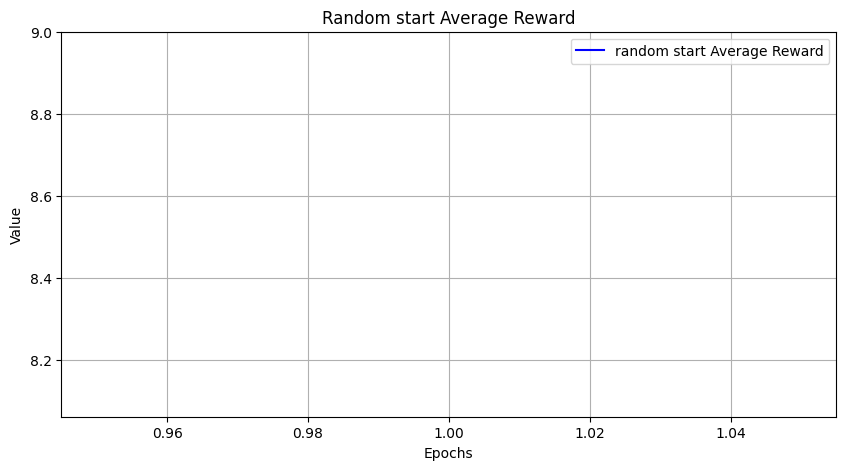

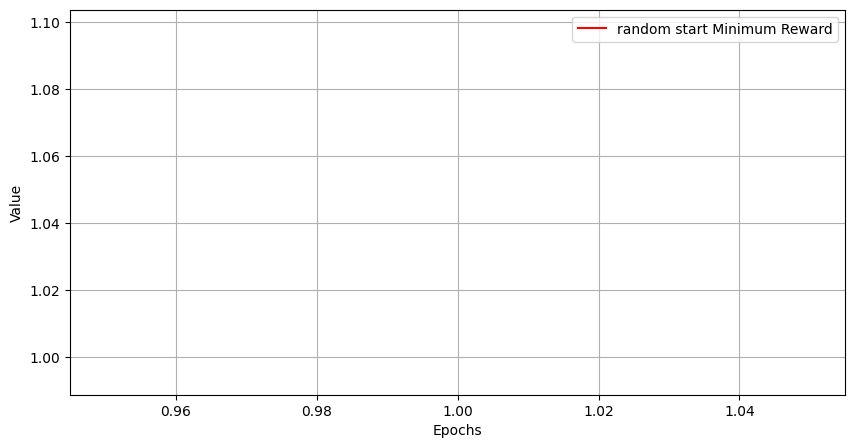

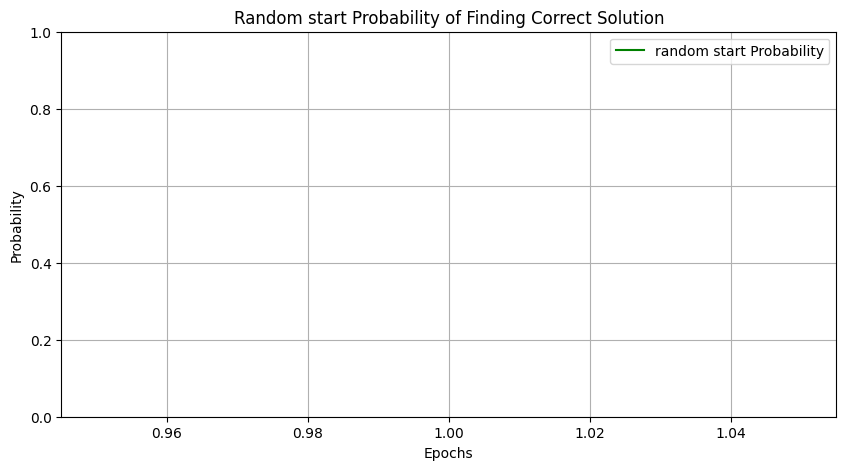

In [ ]:
import matplotlib.pyplot as plt

def plot_rl_qaoa_results(avg_values, min_values, prob_values):
    """
    Plots the stored training values of RL_QAOA across epochs with margin.

    - The first plot shows the average values over epochs with margin.
    - The second plot displays the minimum values over epochs with margin.
    - The third plot represents the probability of finding the correct solution.

    Parameters
    ----------
    avg_values : list
        List of average values over epochs.
    min_values : list
        List of minimum values over epochs.
    prob_values : list
        List of probabilities over epochs.

    The x-axis represents the number of epochs in all graphs.
    """

    epochs = range(1, len(avg_values) + 1)

    # Calculate margins for y-axis limits
    avg_min, avg_max = min(avg_values), max(avg_values)
    min_min, min_max = min(min_values), max(min_values)

    avg_margin = (avg_max - avg_min) * 0.05
    min_margin = (min_max - min_min) * 0.05

    # Plot average values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_values, label="random start Average Reward", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Random start Average Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot minimum values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, min_values, label="random start Minimum Reward", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot probability values
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, prob_values, label="random start Probability", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Probability")
    plt.title("Random start Probability of Finding Correct Solution")
    plt.ylim(0, 1)  # Setting the y-axis range between 0 and 1
    plt.grid(True)
    plt.legend()
    plt.show()
# Example usage with dummy data
avg_values_random = rl_qaoa_rand.avg_values
min_values_random = rl_qaoa_rand.min_values
prob_values_random = rl_qaoa_rand.prob_values

plot_rl_qaoa_results(avg_values_random, min_values_random, prob_values_random)



In [98]:
# RL-QAOA setup
rl_qaoa_rand_beta = RL_QAOA(Q,n,init_params,b_vector = np.array([[25.]*int((n**2)) for i in range(n-n_c)]) ,QAOA_depth=depth,gamma = 0.99,learning_rate_init=[0.00,0.02])
final_config = rl_qaoa_rand_beta.rqaoa_execute()
rl_qaoa_rand_beta.n_c =n_c
print(f"classical_result : {float(final_config[2])},best : {rl_qaoa_rand_beta.node_assignments}" )


# Execute RQAOA
final_config = rl_qaoa_rand_beta.RL_QAOA(episodes=50,epochs=500,correct_ans=float(final_config[2]))

classical_result : -20.186103187399425,best : [1, -1, 1, -1, -1, -1, 1]


Epoch 1/500:   0%|          | 0/50 [00:00<?, ? episode/s]

Epoch 1/500: 100%|██████████| 50/50 [00:02<00:00, 17.48 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.652680382290893
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 6/500: 100%|██████████| 50/50 [00:01<00:00, 32.62 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.292134542431421
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 11/500: 100%|██████████| 50/50 [00:01<00:00, 40.66 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.04385990399879
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 16/500: 100%|██████████| 50/50 [00:01<00:00, 37.70 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.115822114183484
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 21/500: 100%|██████████| 50/50 [00:01<00:00, 36.32 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.6270751824738525
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 26/500: 100%|██████████| 50/50 [00:01<00:00, 34.28 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.137209181769935
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 31/500: 100%|██████████| 50/50 [00:01<00:00, 31.58 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.211467539748337
  Lowest reward obtained: -5.681085501472308
  Best state at lowest value: [ 1 -1 -1 -1 -1 -1 -1]


Epoch 36/500: 100%|██████████| 50/50 [00:01<00:00, 42.19 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.481083075521934
  Lowest reward obtained: 3.545961736886576
  Best state at lowest value: [-1 -1 -1  1 -1 -1 -1]


Epoch 41/500: 100%|██████████| 50/50 [00:01<00:00, 39.54 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.08057419767293
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 46/500: 100%|██████████| 50/50 [00:01<00:00, 38.69 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.402334320438214
  Lowest reward obtained: -1.335010935472026
  Best state at lowest value: [ 1  1 -1 -1 -1 -1 -1]


Epoch 51/500: 100%|██████████| 50/50 [00:01<00:00, 40.24 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.46833187155732
  Lowest reward obtained: -5.068235739592908
  Best state at lowest value: [-1 -1 -1 -1  1 -1 -1]


Epoch 56/500: 100%|██████████| 50/50 [00:01<00:00, 36.40 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.2860823354998026
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 61/500: 100%|██████████| 50/50 [00:01<00:00, 38.32 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.393647837648538
  Lowest reward obtained: 1.1994564045871865
  Best state at lowest value: [-1  1 -1 -1 -1 -1 -1]


Epoch 66/500: 100%|██████████| 50/50 [00:01<00:00, 35.69 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.233298381281143
  Lowest reward obtained: -8.255253902064155
  Best state at lowest value: [ 1 -1  1 -1  1 -1 -1]


Epoch 71/500: 100%|██████████| 50/50 [00:01<00:00, 35.98 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.23781558139855
  Lowest reward obtained: 1.1994564045871865
  Best state at lowest value: [-1  1 -1 -1 -1 -1 -1]


Epoch 76/500: 100%|██████████| 50/50 [00:01<00:00, 37.17 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.870313791994214
  Lowest reward obtained: -16.105748318725944
  Best state at lowest value: [-1 -1  1 -1 -1 -1  1]


Epoch 81/500: 100%|██████████| 50/50 [00:01<00:00, 41.41 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.6990221342998275
  Lowest reward obtained: -3.433728569980922
  Best state at lowest value: [-1 -1  1 -1  1 -1 -1]


Epoch 86/500: 100%|██████████| 50/50 [00:01<00:00, 49.30 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.573306097161115
  Lowest reward obtained: -8.255253902064155
  Best state at lowest value: [ 1 -1  1 -1  1 -1 -1]


Epoch 91/500: 100%|██████████| 50/50 [00:00<00:00, 51.40 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.997854710484279
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 96/500: 100%|██████████| 50/50 [00:01<00:00, 48.91 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.835730886814017
  Lowest reward obtained: -6.197883286239896
  Best state at lowest value: [-1 -1 -1 -1  1  1 -1]


Epoch 101/500: 100%|██████████| 50/50 [00:01<00:00, 48.57 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.896301059022553
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 106/500: 100%|██████████| 50/50 [00:01<00:00, 39.42 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.491318979610988
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 111/500: 100%|██████████| 50/50 [00:01<00:00, 38.77 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.751314713087078
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 116/500: 100%|██████████| 50/50 [00:01<00:00, 38.67 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.935677571922174
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 121/500: 100%|██████████| 50/50 [00:01<00:00, 28.86 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.3436599049149995
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 126/500: 100%|██████████| 50/50 [00:01<00:00, 47.48 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.512257979819388
  Lowest reward obtained: 1.1994564045871865
  Best state at lowest value: [-1  1 -1 -1 -1 -1 -1]


Epoch 131/500: 100%|██████████| 50/50 [00:01<00:00, 46.02 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.639503227049922
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 136/500: 100%|██████████| 50/50 [00:01<00:00, 49.79 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.680087785969189
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 141/500: 100%|██████████| 50/50 [00:01<00:00, 47.43 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.059980675551673
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 146/500: 100%|██████████| 50/50 [00:00<00:00, 51.48 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.271770418281322
  Lowest reward obtained: -5.068235739592908
  Best state at lowest value: [-1 -1 -1 -1  1 -1 -1]


Epoch 151/500: 100%|██████████| 50/50 [00:00<00:00, 50.74 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.8800963082608755
  Lowest reward obtained: -16.105748318725944
  Best state at lowest value: [-1 -1  1 -1 -1 -1  1]


Epoch 156/500: 100%|██████████| 50/50 [00:01<00:00, 49.85 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.2510662666617955
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 161/500: 100%|██████████| 50/50 [00:01<00:00, 48.75 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.218378294238501
  Lowest reward obtained: -17.249854114847352
  Best state at lowest value: [-1  1  1 -1 -1  1 -1]


Epoch 166/500: 100%|██████████| 50/50 [00:01<00:00, 47.90 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.149588876110898
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 171/500: 100%|██████████| 50/50 [00:01<00:00, 48.35 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.630093849778562
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 176/500: 100%|██████████| 50/50 [00:01<00:00, 46.53 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.927452295674808
  Lowest reward obtained: -17.249854114847352
  Best state at lowest value: [-1  1  1 -1 -1  1 -1]


Epoch 181/500: 100%|██████████| 50/50 [00:01<00:00, 38.33 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.454191619863009
  Lowest reward obtained: -5.681085501472308
  Best state at lowest value: [ 1 -1 -1 -1 -1 -1 -1]


Epoch 186/500: 100%|██████████| 50/50 [00:01<00:00, 40.44 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.61151426869322
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 191/500: 100%|██████████| 50/50 [00:01<00:00, 44.22 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 8.386540994812657
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 196/500: 100%|██████████| 50/50 [00:01<00:00, 41.99 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.057342264164422
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 201/500: 100%|██████████| 50/50 [00:01<00:00, 44.89 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.846810356541125
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 206/500: 100%|██████████| 50/50 [00:01<00:00, 38.81 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.707469019502233
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 211/500: 100%|██████████| 50/50 [00:01<00:00, 30.50 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.167311619953557
  Lowest reward obtained: -5.681085501472308
  Best state at lowest value: [ 1 -1 -1 -1 -1 -1 -1]


Epoch 216/500: 100%|██████████| 50/50 [00:01<00:00, 38.90 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.277124535409297
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 221/500: 100%|██████████| 50/50 [00:01<00:00, 41.46 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.423150532084694
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 226/500: 100%|██████████| 50/50 [00:01<00:00, 49.18 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.04187533418497
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 231/500: 100%|██████████| 50/50 [00:01<00:00, 47.43 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.417936012242908
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 236/500: 100%|██████████| 50/50 [00:01<00:00, 46.20 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.655512963135191
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 241/500: 100%|██████████| 50/50 [00:00<00:00, 53.03 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.206616606722056
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 246/500: 100%|██████████| 50/50 [00:01<00:00, 48.73 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.709124485045596
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 251/500: 100%|██████████| 50/50 [00:00<00:00, 50.73 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.275940285130064
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 256/500: 100%|██████████| 50/50 [00:00<00:00, 56.80 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.071354741495181
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 261/500: 100%|██████████| 50/50 [00:00<00:00, 57.27 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.226192673087473
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 266/500: 100%|██████████| 50/50 [00:00<00:00, 54.79 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.996056635648239
  Lowest reward obtained: -5.681085501472308
  Best state at lowest value: [ 1 -1 -1 -1 -1 -1 -1]


Epoch 271/500: 100%|██████████| 50/50 [00:00<00:00, 52.91 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.286098512688215
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 276/500: 100%|██████████| 50/50 [00:00<00:00, 51.77 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.500993293792194
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 281/500: 100%|██████████| 50/50 [00:00<00:00, 52.14 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.539818103697819
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 286/500: 100%|██████████| 50/50 [00:01<00:00, 43.39 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.336975707752476
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 291/500: 100%|██████████| 50/50 [00:01<00:00, 35.40 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.7313091956784685
  Lowest reward obtained: -12.93141276981303
  Best state at lowest value: [-1  1  1 -1  1  1 -1]


Epoch 296/500: 100%|██████████| 50/50 [00:01<00:00, 35.34 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.824235016896912
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 301/500: 100%|██████████| 50/50 [00:01<00:00, 42.10 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.538247024914956
  Lowest reward obtained: -5.068235739592908
  Best state at lowest value: [-1 -1 -1 -1  1 -1 -1]


Epoch 306/500: 100%|██████████| 50/50 [00:00<00:00, 50.35 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.053816131050655
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 311/500: 100%|██████████| 50/50 [00:00<00:00, 53.42 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.289308932959554
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 316/500: 100%|██████████| 50/50 [00:00<00:00, 50.88 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 7.23869128046472
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 321/500: 100%|██████████| 50/50 [00:00<00:00, 51.19 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.472221668279121
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 326/500: 100%|██████████| 50/50 [00:00<00:00, 51.69 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.327684908598817
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 331/500: 100%|██████████| 50/50 [00:01<00:00, 46.83 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.506935745898276
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 336/500: 100%|██████████| 50/50 [00:01<00:00, 49.89 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.966444341895115
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 341/500: 100%|██████████| 50/50 [00:01<00:00, 46.82 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.152931522128606
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 346/500: 100%|██████████| 50/50 [00:01<00:00, 48.08 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.335898807232382
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 351/500: 100%|██████████| 50/50 [00:01<00:00, 44.75 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.179168666772083
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 356/500: 100%|██████████| 50/50 [00:01<00:00, 46.77 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.30903696626186
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 361/500: 100%|██████████| 50/50 [00:01<00:00, 40.16 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 6.504004470387625
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 366/500: 100%|██████████| 50/50 [00:01<00:00, 49.44 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.184866450838278
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 371/500: 100%|██████████| 50/50 [00:01<00:00, 43.48 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.6296242156392164
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 376/500: 100%|██████████| 50/50 [00:01<00:00, 45.32 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.276735052051607
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 381/500: 100%|██████████| 50/50 [00:01<00:00, 43.16 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 3.6258045254290607
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 386/500: 100%|██████████| 50/50 [00:01<00:00, 36.97 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.74936583151871
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 391/500: 100%|██████████| 50/50 [00:01<00:00, 34.56 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.8546814535617475
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 396/500: 100%|██████████| 50/50 [00:01<00:00, 34.44 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.287196700343205
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 401/500: 100%|██████████| 50/50 [00:01<00:00, 31.90 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.556321894700721
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 406/500: 100%|██████████| 50/50 [00:02<00:00, 17.67 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.215970299927967
  Lowest reward obtained: -14.104957741421586
  Best state at lowest value: [ 1 -1  1 -1 -1 -1 -1]


Epoch 411/500: 100%|██████████| 50/50 [00:01<00:00, 40.71 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.161540889610751
  Lowest reward obtained: -14.104957741421586
  Best state at lowest value: [ 1 -1  1 -1 -1 -1 -1]


Epoch 416/500: 100%|██████████| 50/50 [00:01<00:00, 49.69 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.692629201467707
  Lowest reward obtained: -14.104957741421586
  Best state at lowest value: [ 1 -1  1 -1 -1 -1 -1]


Epoch 421/500: 100%|██████████| 50/50 [00:00<00:00, 53.84 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.6634702339198535
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 426/500: 100%|██████████| 50/50 [00:00<00:00, 51.55 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 3.5498265682975183
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 431/500: 100%|██████████| 50/50 [00:01<00:00, 46.16 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.919457755336969
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 436/500: 100%|██████████| 50/50 [00:01<00:00, 47.81 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.468278179809562
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 441/500: 100%|██████████| 50/50 [00:01<00:00, 46.39 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.579550941071098
  Lowest reward obtained: -9.672623654629026
  Best state at lowest value: [-1 -1 -1 -1 -1 -1 -1]


Epoch 446/500: 100%|██████████| 50/50 [00:01<00:00, 43.53 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.704939301753065
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 451/500: 100%|██████████| 50/50 [00:00<00:00, 54.76 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 3.4697767692087123
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 456/500: 100%|██████████| 50/50 [00:01<00:00, 42.86 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 3.8870353126625923
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 461/500: 100%|██████████| 50/50 [00:01<00:00, 49.94 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 3.2746995836020028
  Lowest reward obtained: -14.104957741421586
  Best state at lowest value: [ 1 -1  1 -1 -1 -1 -1]


Epoch 466/500: 100%|██████████| 50/50 [00:00<00:00, 52.04 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 5.524973126902073
  Lowest reward obtained: -9.884215431622385
  Best state at lowest value: [-1 -1 -1 -1 -1  1 -1]


Epoch 471/500: 100%|██████████| 50/50 [00:00<00:00, 52.13 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.784036803747442
  Lowest reward obtained: -14.104957741421586
  Best state at lowest value: [ 1 -1  1 -1 -1 -1 -1]


Epoch 476/500: 100%|██████████| 50/50 [00:00<00:00, 51.69 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 4.130535321681524
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 481/500: 100%|██████████| 50/50 [00:00<00:00, 52.30 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 3.4409980899440167
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 486/500: 100%|██████████| 50/50 [00:00<00:00, 51.22 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 2.0847555536214646
  Lowest reward obtained: -15.053363098419256
  Best state at lowest value: [-1 -1  1 -1 -1  1 -1]


Epoch 491/500: 100%|██████████| 50/50 [00:00<00:00, 51.17 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 3.5024833006178273
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 496/500: 100%|██████████| 50/50 [00:01<00:00, 47.49 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: 3.873323755932896
  Lowest reward obtained: -12.227870064751375
  Best state at lowest value: [-1 -1  1 -1 -1 -1 -1]


Epoch 500/500: 100%|██████████| 50/50 [00:00<00:00, 50.58 episode/s]


In [ ]:
import matplotlib.pyplot as plt

def plot_rl_qaoa_results(avg_values, min_values, prob_values):
    """
    Plots the stored training values of RL_QAOA across epochs with margin.

    - The first plot shows the average values over epochs with margin.
    - The second plot displays the minimum values over epochs with margin.
    - The third plot represents the probability of finding the correct solution.

    Parameters
    ----------
    avg_values : list
        List of average values over epochs.
    min_values : list
        List of minimum values over epochs.
    prob_values : list
        List of probabilities over epochs.

    The x-axis represents the number of epochs in all graphs.
    """

    epochs = range(1, len(avg_values) + 1)

    # Calculate margins for y-axis limits
    avg_min, avg_max = min(avg_values), max(avg_values)
    min_min, min_max = min(min_values), max(min_values)

    avg_margin = (avg_max - avg_min) * 0.05
    min_margin = (min_max - min_min) * 0.05

    # Plot average values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_values, label="random start Average Reward", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Random start Average Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot minimum values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, min_values, label="random start Minimum Reward", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot probability values
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, prob_values, label="random start Probability", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Probability")
    plt.title("Random start Probability of Finding Correct Solution")
    plt.ylim(0, 1)  # Setting the y-axis range between 0 and 1
    plt.grid(True)
    plt.legend()
    plt.show()
# Example usage with dummy data
avg_values_random = rl_qaoa_rand_beta.avg_values
min_values_random = rl_qaoa_rand_beta.min_values
prob_values_random = rl_qaoa_rand_beta.prob_values

plot_rl_qaoa_results(avg_values_random, min_values_random, prob_values_random)



In [79]:
## Optimization with tensorwarm state

# Initial parameters for QAOA
init_params = np.array(param_list)
init_params = np.reshape(init_params,(-1))

# RL-QAOA setup
rl_qaoa = RL_QAOA(Q,Q.shape[0],init_params,b_vector = np.array([25.]*int((Q.shape[0]**2))) ,QAOA_depth=depth,gamma = 0.99,learning_rate_init=[0.02,0.05])
final_config = rl_qaoa.rqaoa_execute()
rl_qaoa.n_c = 2
print(f"classical_result : {float(final_config[2])},best : {rl_qaoa.node_assignments}" )


# Execute RQAOA
final_config = rl_qaoa.RL_QAOA(episodes=50,epochs=200,correct_ans=float(final_config[2]))

classical_result : -6.000479549865009,best : [1, -1, 1, 1]


Epoch 1/200: 100%|██████████| 50/50 [00:00<00:00, 92.99 episode/s] 


  Probability of finding correct solution: 0.9600
  Average reward: -5.987491452282159
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 6/200: 100%|██████████| 50/50 [00:00<00:00, 138.83 episode/s]


  Probability of finding correct solution: 0.9800
  Average reward: -5.998781706873153
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 11/200: 100%|██████████| 50/50 [00:00<00:00, 162.02 episode/s]


  Probability of finding correct solution: 1.0000
  Average reward: -6.000479549865009
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 16/200: 100%|██████████| 50/50 [00:00<00:00, 153.52 episode/s]


  Probability of finding correct solution: 0.9200
  Average reward: -5.964910943100172
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 21/200: 100%|██████████| 50/50 [00:00<00:00, 122.75 episode/s]


  Probability of finding correct solution: 0.9600
  Average reward: -5.987491452282159
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 26/200: 100%|██████████| 50/50 [00:00<00:00, 132.77 episode/s]


  Probability of finding correct solution: 0.9800
  Average reward: -5.989189295274015
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 31/200: 100%|██████████| 50/50 [00:00<00:00, 104.90 episode/s]


  Probability of finding correct solution: 0.9000
  Average reward: -5.945308312996652
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 36/200: 100%|██████████| 50/50 [00:00<00:00, 134.66 episode/s]


  Probability of finding correct solution: 0.8600
  Average reward: -5.969409825723737
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 41/200: 100%|██████████| 50/50 [00:00<00:00, 142.84 episode/s]


  Probability of finding correct solution: 0.9600
  Average reward: -5.977899040683021
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 46/200: 100%|██████████| 50/50 [00:00<00:00, 131.74 episode/s]


  Probability of finding correct solution: 0.9200
  Average reward: -5.966190979186783
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 51/200: 100%|██████████| 50/50 [00:00<00:00, 118.87 episode/s]


  Probability of finding correct solution: 0.9000
  Average reward: -5.982397923306589
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 56/200: 100%|██████████| 50/50 [00:00<00:00, 133.75 episode/s]


  Probability of finding correct solution: 0.8400
  Average reward: -5.938934747934469
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 61/200: 100%|██████████| 50/50 [00:00<00:00, 107.97 episode/s]


  Probability of finding correct solution: 0.8200
  Average reward: -5.918052081744338
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 66/200: 100%|██████████| 50/50 [00:00<00:00, 116.95 episode/s]


  Probability of finding correct solution: 0.8600
  Average reward: -5.969409825723737
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 71/200: 100%|██████████| 50/50 [00:00<00:00, 114.67 episode/s]


  Probability of finding correct solution: 0.8600
  Average reward: -5.921447767728052
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 76/200: 100%|██████████| 50/50 [00:00<00:00, 102.51 episode/s]


  Probability of finding correct solution: 0.6400
  Average reward: -5.854809436821941
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 81/200: 100%|██████████| 50/50 [00:00<00:00, 128.64 episode/s]


  Probability of finding correct solution: 0.5600
  Average reward: -5.810928454544577
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 86/200: 100%|██████████| 50/50 [00:00<00:00, 133.13 episode/s]


  Probability of finding correct solution: 0.5800
  Average reward: -5.813906333623047
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 91/200: 100%|██████████| 50/50 [00:00<00:00, 111.54 episode/s]


  Probability of finding correct solution: 0.4400
  Average reward: -5.732314479312862
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 96/200: 100%|██████████| 50/50 [00:00<00:00, 120.11 episode/s]


  Probability of finding correct solution: 0.3200
  Average reward: -5.674165363366036
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 101/200: 100%|██████████| 50/50 [00:00<00:00, 90.66 episode/s]


  Probability of finding correct solution: 0.2800
  Average reward: -5.654144926357273
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 106/200: 100%|██████████| 50/50 [00:00<00:00, 107.65 episode/s]


  Probability of finding correct solution: 0.2400
  Average reward: -5.65074924037356
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 111/200: 100%|██████████| 50/50 [00:00<00:00, 111.07 episode/s]


  Probability of finding correct solution: 0.2000
  Average reward: -5.591079120881636
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 116/200: 100%|██████████| 50/50 [00:00<00:00, 95.47 episode/s]


  Probability of finding correct solution: 0.2200
  Average reward: -5.646491325208476
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 121/200: 100%|██████████| 50/50 [00:00<00:00, 107.05 episode/s]


  Probability of finding correct solution: 0.1200
  Average reward: -5.620097323137531
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 126/200: 100%|██████████| 50/50 [00:00<00:00, 113.81 episode/s]


  Probability of finding correct solution: 0.1400
  Average reward: -5.602610342931114
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 131/200: 100%|██████████| 50/50 [00:00<00:00, 107.78 episode/s]


  Probability of finding correct solution: 0.1000
  Average reward: -5.551252598951715
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 136/200: 100%|██████████| 50/50 [00:00<00:00, 115.21 episode/s]


  Probability of finding correct solution: 0.1600
  Average reward: -5.575530951125558
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 141/200: 100%|██████████| 50/50 [00:00<00:00, 117.14 episode/s]


  Probability of finding correct solution: 0.1200
  Average reward: -5.603472572112484
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 146/200: 100%|██████████| 50/50 [00:00<00:00, 104.21 episode/s]


  Probability of finding correct solution: 0.0600
  Average reward: -5.5753541116787995
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 151/200: 100%|██████████| 50/50 [00:00<00:00, 129.57 episode/s]


  Probability of finding correct solution: 0.1200
  Average reward: -5.5830077128275954
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 156/200: 100%|██████████| 50/50 [00:00<00:00, 84.29 episode/s]


  Probability of finding correct solution: 0.0000
  Average reward: -5.570260582703229
  Lowest reward obtained: -5.915587400272173
  Best state at lowest value: [-1 -1 -1 -1]


Epoch 161/200: 100%|██████████| 50/50 [00:00<00:00, 74.83 episode/s]


  Probability of finding correct solution: 0.0800
  Average reward: -5.597516813955544
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 166/200: 100%|██████████| 50/50 [00:00<00:00, 137.15 episode/s]


  Probability of finding correct solution: 0.0800
  Average reward: -5.5783319907572695
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 171/200: 100%|██████████| 50/50 [00:00<00:00, 131.91 episode/s]


  Probability of finding correct solution: 0.0600
  Average reward: -5.584946523277937
  Lowest reward obtained: -6.000479549865009
  Best state at lowest value: [ 1 -1  1  1]


Epoch 173/200:  90%|█████████ | 45/50 [00:00<00:00, 132.87 episode/s]


KeyboardInterrupt: 

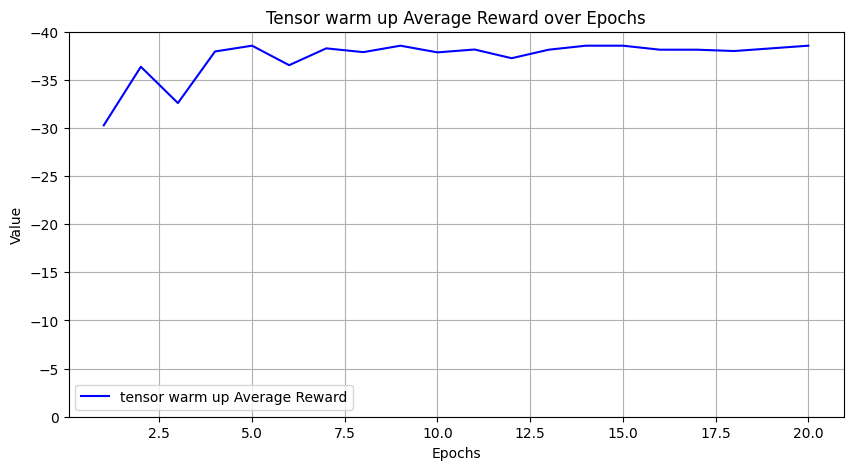

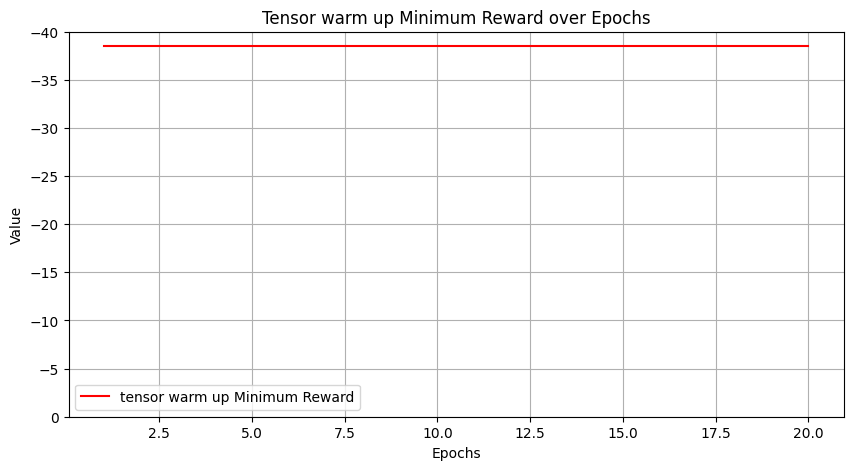

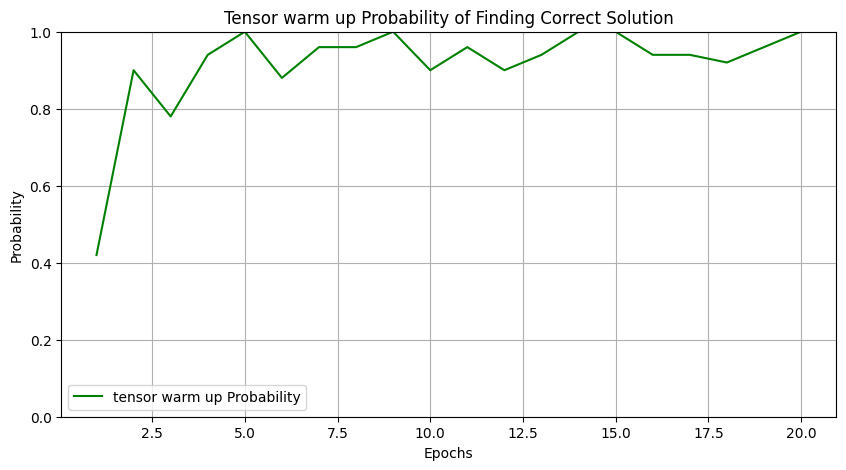

In [22]:
import matplotlib.pyplot as plt

def plot_rl_qaoa_results(avg_values, min_values, prob_values):
    """
    Plots the stored training values of RL_QAOA across epochs with margin.

    - The first plot shows the average values over epochs with margin.
    - The second plot displays the minimum values over epochs with margin.
    - The third plot represents the probability of finding the correct solution.

    Parameters
    ----------
    avg_values : list
        List of average values over epochs.
    min_values : list
        List of minimum values over epochs.
    prob_values : list
        List of probabilities over epochs.

    The x-axis represents the number of epochs in all graphs.
    """

    epochs = range(1, len(avg_values) + 1)

    # Calculate margins for y-axis limits
    avg_min, avg_max = min(avg_values), max(avg_values)
    min_min, min_max = min(min_values), max(min_values)

    avg_margin = (avg_max - avg_min) * 0.05
    min_margin = (min_max - min_min) * 0.05

    # Plot average values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_values, label="tensor warm up Average Reward", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Tensor warm up Average Reward over Epochs")
    plt.ylim(0,-40)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot minimum values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, min_values, label="tensor warm up Minimum Reward", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Tensor warm up Minimum Reward over Epochs")
    plt.ylim(0,-40)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot probability values
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, prob_values, label="tensor warm up Probability", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Probability")
    plt.title("Tensor warm up Probability of Finding Correct Solution")
    plt.ylim(0, 1)  # Setting the y-axis range between 0 and 1
    plt.grid(True)
    plt.legend()
    plt.show()
# Example usage with dummy data
avg_values = rl_qaoa.avg_values
min_values = rl_qaoa.min_values
prob_values = rl_qaoa.prob_values

plot_rl_qaoa_results(avg_values, min_values, prob_values)
